![UBA](assets/UBA_header_black.png)

# Dataset seleccionado: BA Ecobici
Contiene información sobre los viajes realizados a través del servicio público de bicicletas BA Ecobici, que opera en la Ciudad Autónoma de Buenos Aires.

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import requests
import zipfile
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import folium

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Ingesta de los datos

In [2]:
"""USUARIOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_usuarios_2024.csv"
RECORRIDOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_recorridos_realizados_2024.zip"
USUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")
RECORRIDOS_ZIP = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.zip")
RECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")
# Descarga de los archivos
GET_FILES = False

if GET_FILES:
    def download_file(url, dest_path):
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(dest_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)


    download_file(USUARIOS_FILE_URL, USUARIOS_CSV)
    download_file(RECORRIDOS_FILE_URL, RECORRIDOS_ZIP)

    with zipfile.ZipFile(RECORRIDOS_ZIP) as zip_ref:
        zip_contents = zip_ref.namelist()
        if zip_contents:
            zip_ref.extract(zip_contents[0], path=RECORRIDOS_CSV.parent)
            extracted_file = RECORRIDOS_CSV.parent / zip_contents[0]
            extracted_file.rename(RECORRIDOS_CSV)

    RECORRIDOS_ZIP.unlink()

users_df = pd.read_csv(USUARIOS_CSV)
rides_df = pd.read_csv(RECORRIDOS_CSV)"""

'USUARIOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_usuarios_2024.csv"\nRECORRIDOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_recorridos_realizados_2024.zip"\nUSUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")\nRECORRIDOS_ZIP = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.zip")\nRECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")\n# Descarga de los archivos\nGET_FILES = False\n\nif GET_FILES:\n    def download_file(url, dest_path):\n        response = requests.get(url, stream=True)\n        response.raise_for_status()\n        with open(dest_path, \'wb\') as f:\n            for chunk in response.iter_content(chunk_size=8192):\n                f.write(chunk)\n\n\n    download_file(USUARIOS_FILE_URL, USUARIOS_CSV)\n    download_file(

In [3]:
users_df = pd.read_csv("datasets/usuarios_2024.csv")
rides_df = pd.read_csv("datasets/recorridos_realizados_2024.csv")

# Hipótesis
- Los fines de semana hay una mayor cantidad de usuarios nuevos
- Los fines de semana se realizan más recorridos
- Las estaciones ubicadas cerca de centros de transbordo (trenes, subtes y colectivos) son las más utilizadas
- La mayoría de los viajes ocurre en horas pico laborales
- La duración promedio de los recorridos es mayor los fines de semana
- Las estaciones ubicadas en zonas comerciales son más usadas en horario laboral
- En invierno disminuye la cantidad de viajes

# Posibilidades abiertas para el futuro
Si bien no forman parte del objetivo actual, este análisis podría extenderse utilizando modelos de aprendizaje automático para:
- Predecir demanda futura por estación
- Estimar la duración de un recorrido en función del día y hora de inicio <br>
<br>
Para esto, se podría cruzar con otros datasets:
- BA Ecobici (de años anteriores y posteriores)
- Clima (Servicio Metereológico Nacional)
- Transporte público (datos de viajes en otros medios de transporte)
- Eventos masivos (recitales, eventos deportivos, eventos gratuitos del GCBA, etc.)

# Dataset de usuarios (CSV)
Contiene el listado de usuarios del servicio, que se dieron de alta en 2024.

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197079 entries, 0 to 197078
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_usuario      197079 non-null  int64 
 1   genero_usuario  197079 non-null  object
 2   edad_usuario    197079 non-null  int64 
 3   fecha_alta      197079 non-null  object
 4   hora_alta       197079 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


In [5]:
users_df.head()

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,1083579,OTHER,23,2024-01-01,01:59:02
1,1083608,OTHER,36,2024-01-01,02:55:46
2,1083612,OTHER,38,2024-01-01,03:13:15
3,1083616,FEMALE,21,2024-01-01,03:40:54
4,1083631,MALE,36,2024-01-01,05:02:35


In [6]:
users_df.describe()

,id_usuario,edad_usuario
count,1.970790e+05,197079.000000
mean,1.182078e+06,30.764521
std,5.689283e+04,18.896208
min,1.083538e+06,4.000000
25%,1.132808e+06,21.000000
50%,1.182078e+06,27.000000
75%,1.231348e+06,37.000000
max,1.280619e+06,2021.000000


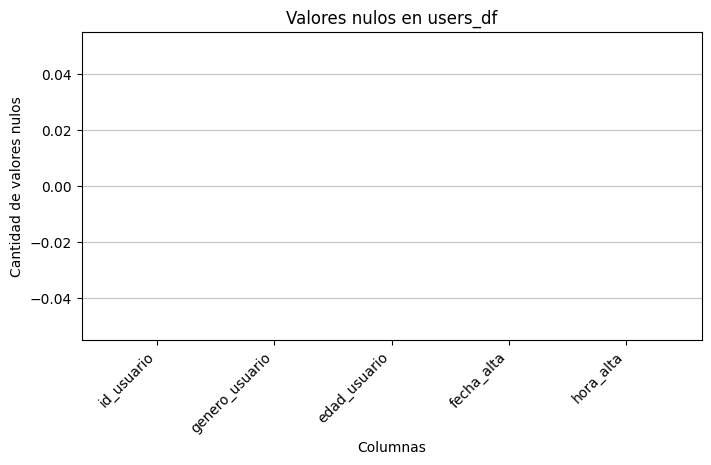

In [7]:
# Exploración de valores nulos
plt.figure(figsize=(8, 4))
plt.grid(axis='y', alpha=0.75)
plt.bar(users_df.columns, users_df.isnull().sum(), align='center', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en users_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

In [8]:
# Usuarios duplicados
duplicated_users = users_df[users_df.duplicated(subset='id_usuario', keep=False)]
print(f"Cantidad de usuarios duplicados: {duplicated_users['id_usuario'].nunique()}")
duplicated_users.sort_values(by='id_usuario').head(10)

Cantidad de usuarios duplicados: 0


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta


##### Exploración de generos

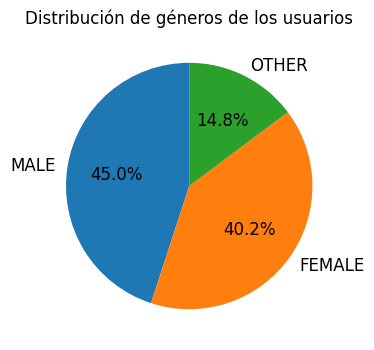

In [9]:
# Pie chart de los géneros de usuarios
plt.figure(figsize=(4, 4))
users_df['genero_usuario'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de los usuarios')
plt.ylabel('')
plt.show()

In [10]:
# Conteo de usuarios por género
gender_counts = users_df['genero_usuario'].value_counts()
print(gender_counts)

genero_usuario
MALE      88656
FEMALE    79310
OTHER     29113
Name: count, dtype: int64


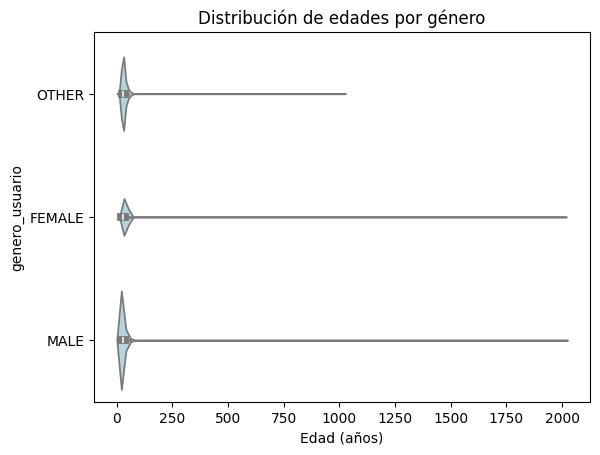

In [11]:
sns.violinplot(y=users_df['genero_usuario'], x=users_df['edad_usuario'], color='lightblue', inner='box')
plt.title('Distribución de edades por género')
plt.xlabel('Edad (años)')
plt.show()

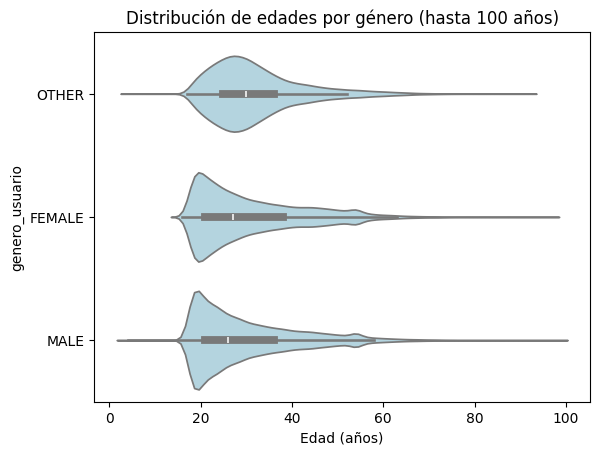

In [12]:
# Violin de edades por género (edades hasta 100 años)
mask_edad = users_df['edad_usuario'] <= 100
sns.violinplot(y=users_df['genero_usuario'][mask_edad], x=users_df['edad_usuario'][mask_edad], color='lightblue', inner='box')
plt.title('Distribución de edades por género (hasta 100 años)')
plt.xlabel('Edad (años)')
plt.show()

##### Exploración de edades

In [13]:
# Edades de usuarios menores de 18 años
users_df[users_df['edad_usuario'] < 18].value_counts('edad_usuario').sort_index()

edad_usuario
4      2
5      4
15     3
16     7
17    16
Name: count, dtype: int64

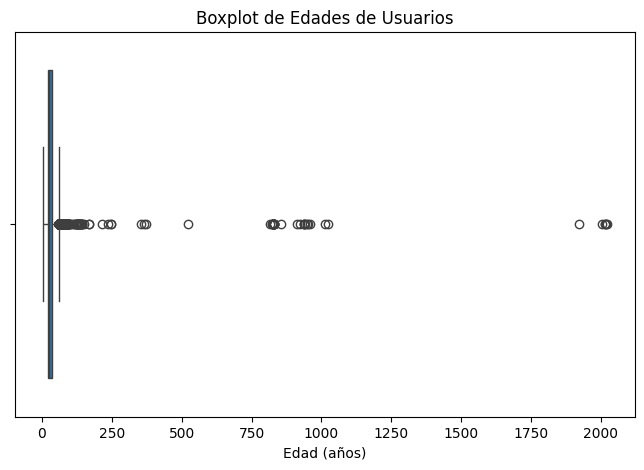

In [14]:
# Boxplot de edades
plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df['edad_usuario'])
plt.title('Boxplot de Edades de Usuarios')
plt.xlabel('Edad (años)')
plt.show()

In [15]:
# Cuartiles en años
Q1 = users_df['edad_usuario'].quantile(0.25)
Q2 = users_df['edad_usuario'].quantile(0.50)
Q3 = users_df['edad_usuario'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 (25%):", Q1)
print("Q2 (Mediana, 50%):", Q2)
print("Q3 (75%):", Q3)
print("IQR (Rango Intercuartílico):", IQR)

Q1 (25%): 21.0
Q2 (Mediana, 50%): 27.0
Q3 (75%): 37.0
IQR (Rango Intercuartílico): 16.0


In [16]:
# Media moda mediana de edades (en años)
mean = users_df['edad_usuario'].mean().round(2)
median = users_df['edad_usuario'].median().round(2)
mode = users_df['edad_usuario'].mode()[0].round(2)
var = users_df['edad_usuario'].var().round(2)
std_dev = users_df['edad_usuario'].std().round(2)

print(f"Media: {mean} años")
print(f"Mediana: {median} años")
print(f"Moda: {mode} años")
print(f"Varianza: {var} años²")
print(f"Desviación estándar: {std_dev} años")

Media: 30.76 años
Mediana: 27.0 años
Moda: 18 años
Varianza: 357.07 años²
Desviación estándar: 18.9 años


In [17]:
print(f"Asímetría de edad: {users_df['edad_usuario'].skew()}")
print(f"Curtosis de edad: {users_df['edad_usuario'].kurtosis()}")

Asímetría de edad: 47.583628237635786
Curtosis de edad: 4173.90573483157


La edad de usuario es altamente asimétrica:
- Tiene muchos valores bajos
- Tiene pocos valores extremadamente altos (estiran la cola a derecha)

La edad de usuario tiene una curtosis muy alta:
- Tiene una distribución 'picuda'
- Tiene una cola bien pesada

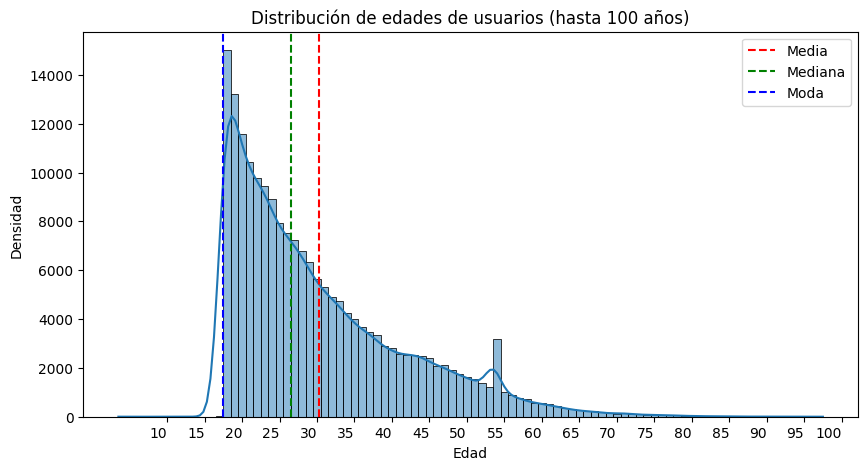

In [18]:
# Histograma de edades (hasta 100 años)
mask_edad = users_df['edad_usuario'] <= 100
plt.figure(figsize=(10, 5))
ax = sns.histplot(users_df[mask_edad]['edad_usuario'], kde=True, binwidth=1)
ticks = [t + 0.5 for t in range(10, 101, 5)]  # Esto es para centrar los bines en los ticks
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels([str(int(tick)) for tick in ticks], ha='right')
plt.title('Distribución de edades de usuarios (hasta 100 años)')
plt.xlabel('Edad')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()


Text(0, 0.5, 'Densidad')

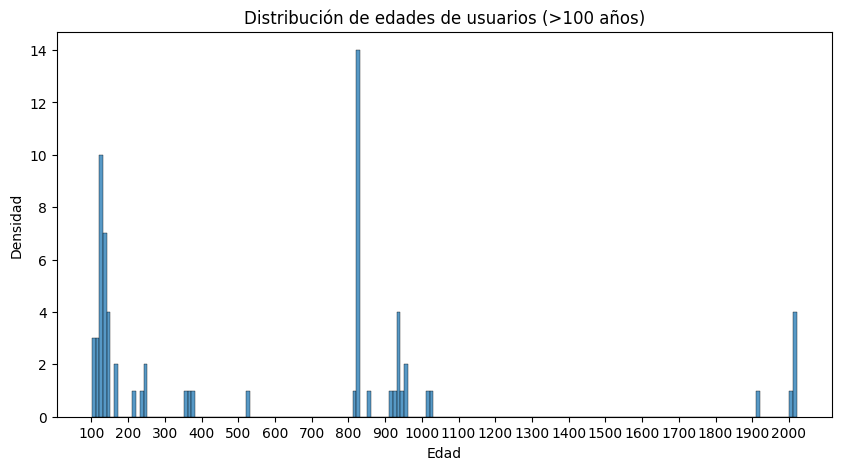

In [19]:
# Histograma de edades de mas de 100 años
mask_edad = users_df["edad_usuario"] > 100
plt.figure(figsize=(10, 5))
sns.histplot(users_df[mask_edad]['edad_usuario'], binwidth=10)
plt.title('Distribución de edades de usuarios (>100 años)')
plt.xticks(range(100, users_df['edad_usuario'].max() + 1, 100))
plt.xlabel('Edad')
plt.ylabel('Densidad')

In [20]:
# 10 usuarios mas 'viejos'
users_df.sort_values(by='edad_usuario', ascending=False).head(10)

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
56690,1109473,MALE,2021,2024-02-11,20:24:45
104417,1238144,MALE,2019,2024-10-27,20:08:47
124365,1130915,FEMALE,2016,2024-03-21,21:19:50
184254,1202670,MALE,2016,2024-09-07,18:39:34
66885,1189702,FEMALE,2004,2024-08-09,22:34:35
10936,1150325,FEMALE,1921,2024-04-29,13:33:57
137312,1277262,OTHER,1022,2024-12-27,13:11:42
62421,1167228,MALE,1012,2024-06-16,15:20:11
18616,1199423,OTHER,960,2024-09-02,17:37:56
92904,1279416,OTHER,952,2024-12-30,09:20:27


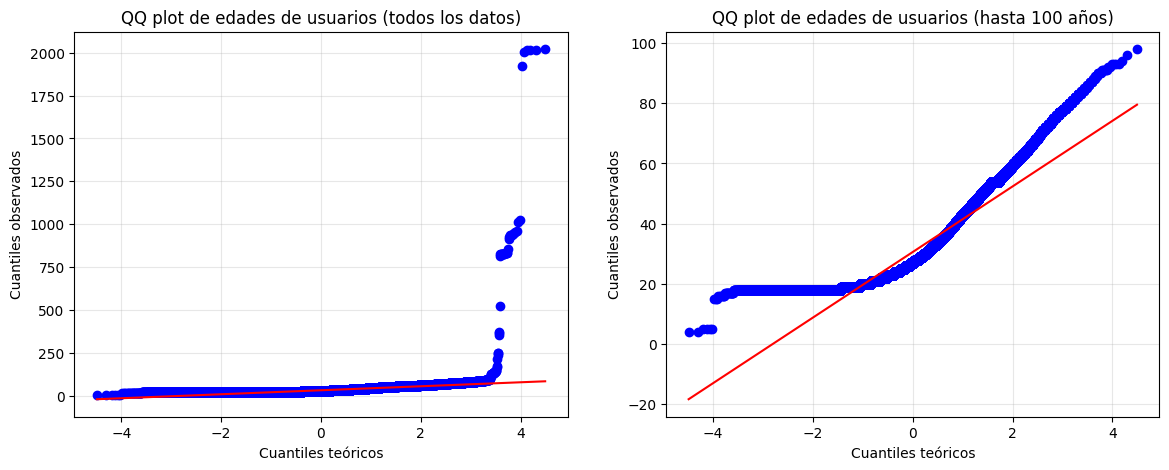

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# QQ plot con todos los datos de edad
stats.probplot(users_df['edad_usuario'], dist="norm", plot=ax1)
ax1.set_title('QQ plot de edades de usuarios (todos los datos)', fontsize=12)
ax1.set_xlabel('Cuantiles teóricos')
ax1.set_ylabel('Cuantiles observados')
ax1.grid(alpha=0.3)

# QQ plot solo con edades hasta 100 años
mask_edad = users_df['edad_usuario'] <= 100
stats.probplot(users_df[mask_edad]['edad_usuario'], dist="norm", plot=ax2)
ax2.set_title('QQ plot de edades de usuarios (hasta 100 años)', fontsize=12)
ax2.set_xlabel('Cuantiles teóricos')
ax2.set_ylabel('Cuantiles observados')
ax2.grid(alpha=0.3)

plt.show()

El QQ plot muestra
- Clara desviación respecto a la normalidad
- Cola pesada
- Muchas edades pequeñas y pocas edades muy grandes

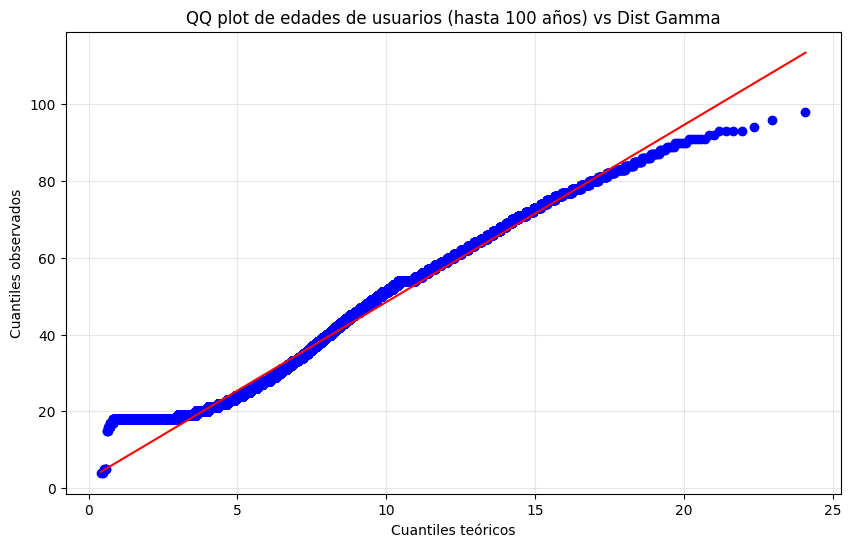

In [22]:
# QQ plot contra distribución Gamma
mask_edad = users_df['edad_usuario'] <= 100

a, loc, scale = stats.gamma.fit(users_df[mask_edad]['edad_usuario'])

fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(users_df[mask_edad]['edad_usuario'], dist=stats.gamma, sparams=(a,), plot=ax)
ax.set_title('QQ plot de edades de usuarios (hasta 100 años) vs Dist Gamma', fontsize=12)
ax.set_xlabel('Cuantiles teóricos')
ax.set_ylabel('Cuantiles observados')
ax.grid(alpha=0.3)
plt.show()

##### Exploración de fecha y hora de alta

In [23]:
# Parseo de columnas de fecha y hora
users_df['fecha_alta_dt'] = pd.to_datetime(users_df['fecha_alta'], errors='coerce')
users_df['hora_alta_dt'] = pd.to_datetime(users_df['hora_alta'], format='%H:%M:%S', errors='coerce').dt.time
users_df['dia_semana'] = users_df['fecha_alta_dt'].dt.day_name()

In [24]:
# 10 fechas de alta mas repetidas
users_df['fecha_alta_dt'].value_counts().head(10)

fecha_alta_dt
2024-11-09    1720
2024-05-09    1315
2024-10-11    1278
2024-09-29    1197
2024-10-27    1154
2024-11-10    1128
2024-11-18    1119
2024-09-08    1076
2024-01-24    1062
2024-09-15    1041
Name: count, dtype: int64

In [25]:
# 10 horas de alta mas repetidas
users_df['hora_alta_dt'].apply(lambda x: x.hour).value_counts().head(10)

hora_alta_dt
16    18531
15    17762
17    17386
14    15614
18    14997
13    14042
12    13425
11    11756
19    11261
10     8984
Name: count, dtype: int64

In [26]:
# Altas por dia de la semana
users_df['dia_semana'].value_counts()

dia_semana
Sunday       31073
Saturday     28801
Monday       28599
Thursday     27978
Friday       27115
Tuesday      26841
Wednesday    26672
Name: count, dtype: int64

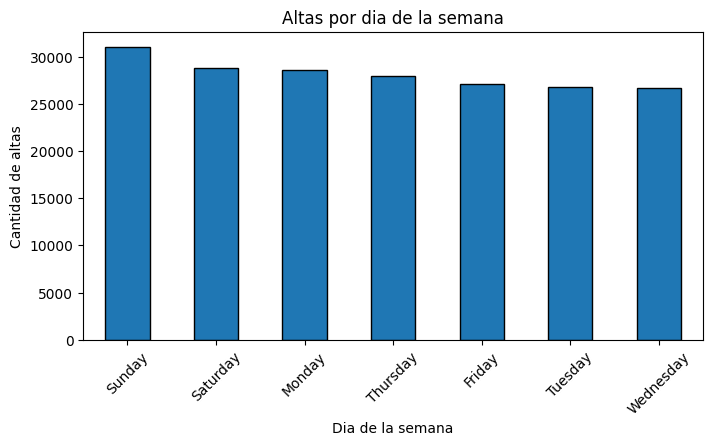

In [27]:
# Bar chart de altas por dia de la semana
plt.figure(figsize=(8, 4))
users_df['dia_semana'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Altas por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad de altas')
plt.xticks(rotation=45)
plt.show()

# Dataset de recorridos (CSV)
Contiene información de los viajes realizados.

In [28]:
rides_df.info()
# duracion_recorrido está en segundos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560404 entries, 0 to 3560403
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id_recorrido                int64  
 1   duracion_recorrido          int64  
 2   fecha_origen_recorrido      object 
 3   id_estacion_origen          int64  
 4   nombre_estacion_origen      object 
 5   direccion_estacion_origen   object 
 6   long_estacion_origen        float64
 7   lat_estacion_origen         float64
 8   fecha_destino_recorrido     object 
 9   id_estacion_destino         int64  
 10  nombre_estacion_destino     object 
 11  direccion_estacion_destino  object 
 12  long_estacion_destino       float64
 13  lat_estacion_destino        float64
 14  id_usuario                  float64
 15  modelo_bicicleta            object 
 16  genero                      object 
dtypes: float64(5), int64(4), object(8)
memory usage: 461.8+ MB


In [29]:
rides_df.head()

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
0,24496816,17,2024-12-31 08:18:58,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,2024-12-31 08:19:15,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1166678.0,FIT,FEMALE
1,24492524,2,2024-12-30 19:21:45,251,388 - Plaza Jose C Paz,Dr. Prof. Pedro Chutro 2881,-58.402483,-34.641728,2024-12-30 19:21:47,41,041 - PARQUE PATRICIOS II,Av Caseros 3015,-58.405888,-34.637123,1133415.0,FIT,FEMALE
2,24493951,0,2024-12-30 21:08:03,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,NaN,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,1158360.0,ICONIC,FEMALE
3,24494848,6575,2024-12-30 23:22:17,177,177 -PLANETARIO,Av. Belisario Roldán y Av. Sarmiento,-58.411598,-34.571079,2024-12-31 01:11:52,336,207 - PLAZA ARENALES,Nueva York 3949,-58.511146,-34.599731,1224331.0,FIT,FEMALE
4,24495039,3162,2024-12-30 23:52:00,359,250 - Fleni,2292 Montañeses,-58.450479,-34.555602,2024-12-31 00:44:42,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,1280053.0,ICONIC,FEMALE


In [30]:
rides_df.describe()

,id_recorrido,duracion_recorrido,id_estacion_origen,long_estacion_origen,lat_estacion_origen,id_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario
count,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06
mean,2.234132e+07,1.274680e+03,2.355957e+02,-5.842302e+01,-3.459877e+01,2.371506e+02,-5.842318e+01,-3.459896e+01,7.908728e+05
std,1.257073e+06,9.582717e+03,1.657999e+02,3.830469e-02,2.441487e-02,1.657100e+02,3.848631e-02,2.477407e-02,3.881981e+05
min,2.018097e+07,0.000000e+00,2.000000e+00,-5.852710e+01,-3.468777e+01,2.000000e+00,-5.852710e+01,-3.468777e+01,2.400000e+01
25%,2.123866e+07,4.930000e+02,9.300000e+01,-5.844965e+01,-3.461635e+01,9.600000e+01,-5.844966e+01,-3.461649e+01,5.118240e+05
50%,2.235131e+07,8.810000e+02,1.990000e+02,-5.842095e+01,-3.460028e+01,2.000000e+02,-5.842095e+01,-3.460075e+01,9.131670e+05
75%,2.343700e+07,1.473000e+03,3.780000e+02,-5.839374e+01,-3.458255e+01,3.790000e+02,-5.839374e+01,-3.458234e+01,1.113537e+06
max,2.450328e+07,2.571165e+06,5.770000e+02,-5.835547e+01,-3.453669e+01,5.770000e+02,-5.835547e+01,-3.453669e+01,1.280599e+06


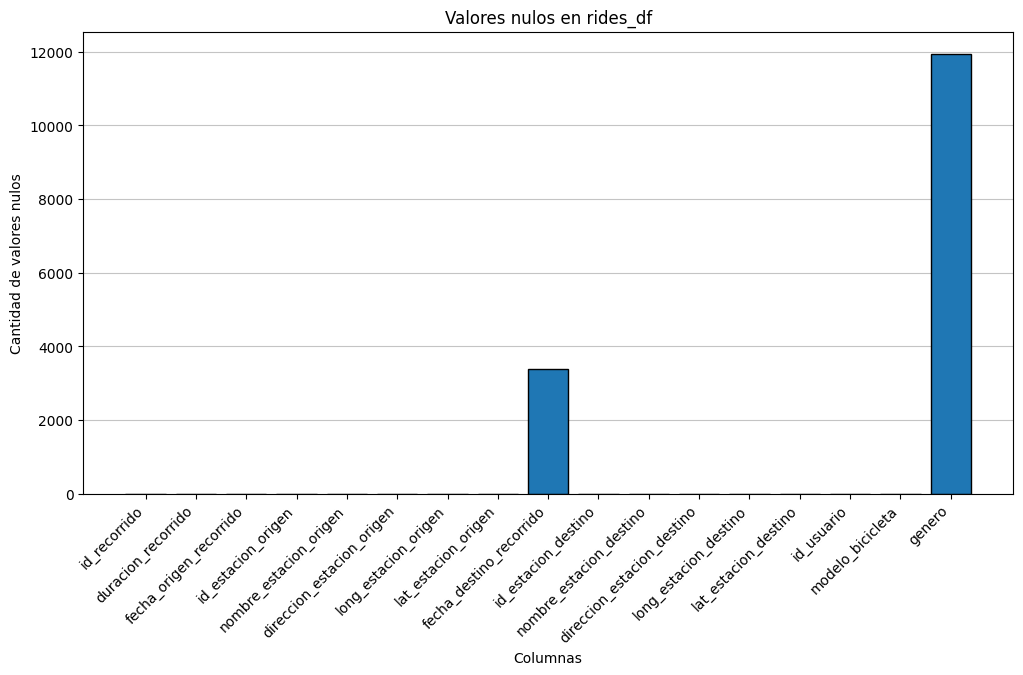

In [31]:
# Exploración de valores nulos
plt.figure(figsize=(12, 6))
plt.grid(axis='y', alpha=0.75)
plt.bar(rides_df.columns, rides_df.isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

##### Exploración de duraciones de recorrido

In [32]:
rides_df['duracion_recorrido_min'] = rides_df['duracion_recorrido'] / 60

In [33]:
# Recorrido mas largo en días
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido'].max()/3600/24, 2)} días")

Recorrido más largo: 29.76 días


In [34]:
# Recorrido mas corto en minutos
print(f"Recorrido más corto: {round(rides_df['duracion_recorrido_min'].min(), 2)} minutos")

# Recorrido mas largo en minutos
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido_min'].max(), 2)} minutos")

Recorrido más corto: 0.0 minutos
Recorrido más largo: 42852.75 minutos


In [35]:
# El usuario que más tiempo usó las bicicletas
user_durations = rides_df.groupby('id_usuario')['duracion_recorrido'].sum()
max_user_id = user_durations.idxmax()
max_user_duration = user_durations.max()

print(f"Usuario más activo: {max_user_duration/3600:.2f} hs")

Usuario más activo: 738.33 hs


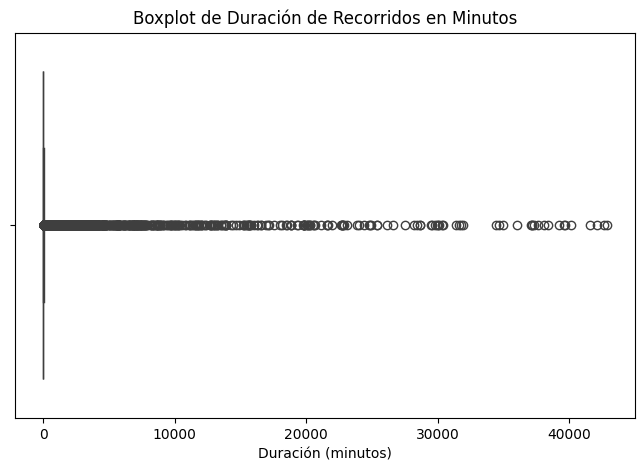

In [36]:
# Boxplot de duracion de recorridos en minutos
plt.figure(figsize=(8, 5))
sns.boxplot(x=rides_df['duracion_recorrido_min'])
plt.title('Boxplot de Duración de Recorridos en Minutos')
plt.xlabel('Duración (minutos)')
plt.show()

In [37]:
# Cuartiles en minutos
Q1 = rides_df['duracion_recorrido_min'].quantile(0.25)
Q2 = rides_df['duracion_recorrido_min'].quantile(0.50)
Q3 = rides_df['duracion_recorrido_min'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 (25%):", Q1)
print("Q2 (Mediana, 50%):", Q2)
print("Q3 (75%):", Q3)
print("IQR (Rango Intercuartílico):", IQR)

Q1 (25%): 8.216666666666667
Q2 (Mediana, 50%): 14.683333333333334
Q3 (75%): 24.55
IQR (Rango Intercuartílico): 16.333333333333336


In [38]:
# Media moda mediana de duraciones (en minutos)
mean = rides_df['duracion_recorrido_min'].mean().round(2)
median = rides_df['duracion_recorrido_min'].median().round(2)
mode = rides_df['duracion_recorrido_min'].mode()[0].round(2)
var = rides_df['duracion_recorrido_min'].var().round(2)
std_dev = rides_df['duracion_recorrido_min'].std().round(2)

print(f"Media: {mean} min")
print(f"Mediana: {median} min")
print(f"Moda: {mode} min")
print(f"Varianza: {var} min²")
print(f"Desviación estándar: {std_dev} min")

Media: 21.24 min
Mediana: 14.68 min
Moda: 0.03 min
Varianza: 25507.91 min²
Desviación estándar: 159.71 min


In [39]:
print(f"Asímetría de duracion: {rides_df['duracion_recorrido_min'].skew():.2f}")
print(f"Curtosis de duracion: {rides_df['duracion_recorrido_min'].kurtosis():.2f}")

Asímetría de duracion: 156.24
Curtosis de duracion: 30117.53


La duración de recorridos es altamente asimétrica:
- Tiene muchos valores bajos
- Tiene pocos valores extremadamente altos (estiran la cola a derecha)

La duración de recorridos tiene una curtosis muy alta:
- Tiene una distribución 'picuda'
- Tiene una cola bien pesada

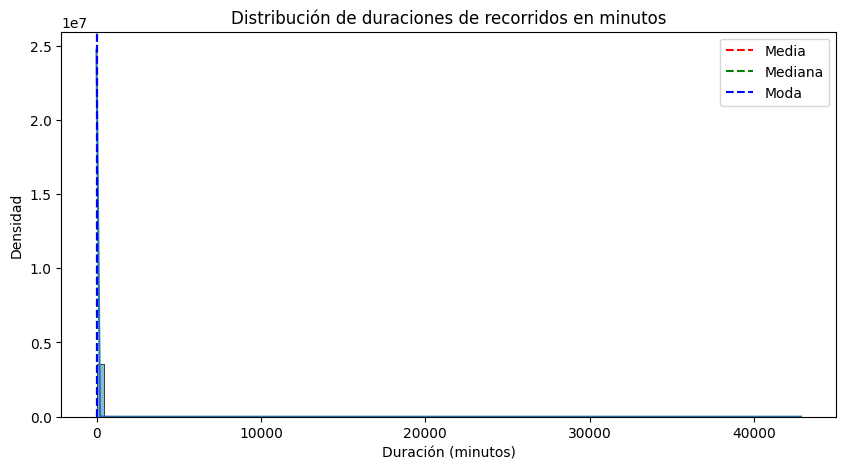

In [40]:
# Histograma de duraciones de recorridos en minutos
plt.figure(figsize=(10, 5))
ax =sns.histplot(rides_df['duracion_recorrido_min'], bins=100, kde=True)
plt.title('Distribución de duraciones de recorridos en minutos')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()

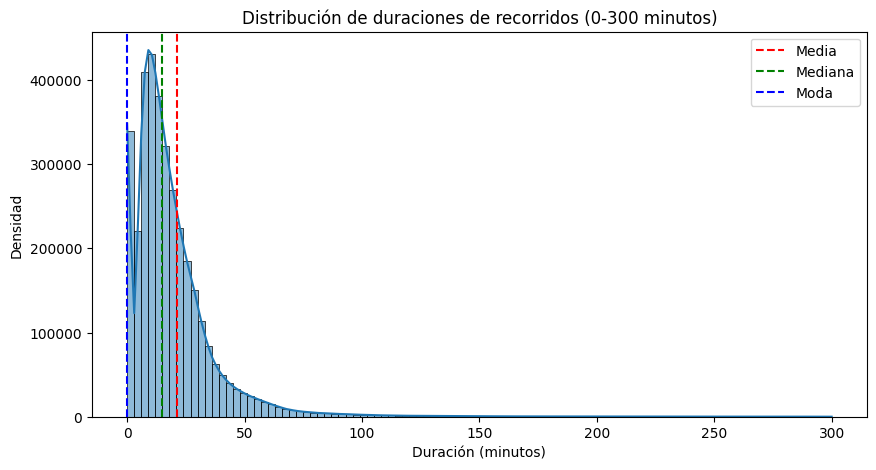

In [41]:
# Histograma de duraciones de recorridos en minutos (>0 y < 300)
mask_duration = (rides_df['duracion_recorrido_min'] > 0) & (rides_df['duracion_recorrido_min'] < 300)
plt.figure(figsize=(10, 5))
ax = sns.histplot(rides_df[mask_duration]['duracion_recorrido_min'], bins=100, kde=True)
plt.title('Distribución de duraciones de recorridos (0-300 minutos)')
plt.xlabel('Duración (minutos)')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()

##### Exploración de fecha origen de recorrido

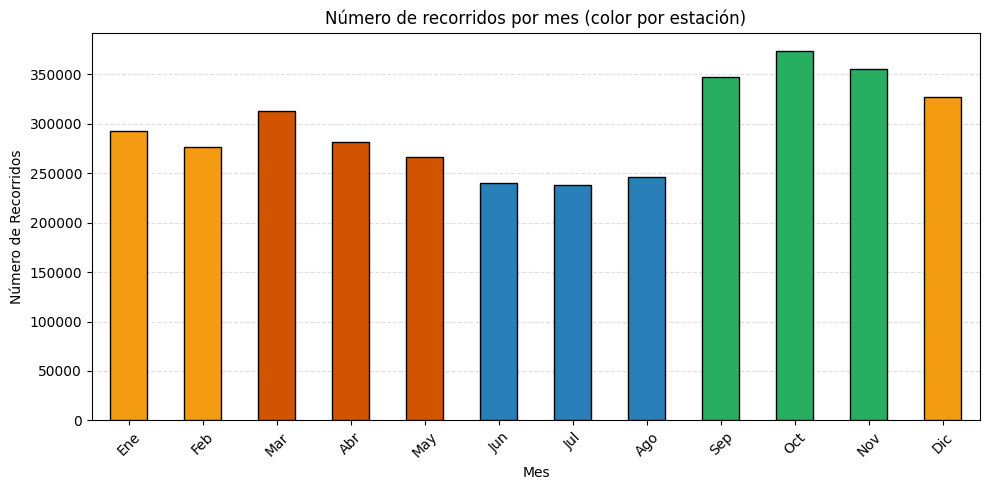

In [42]:
rides_df['fecha_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'])
rides_df['mes'] = rides_df['fecha_origen_recorrido'].dt.month

counts = rides_df['mes'].value_counts().reindex(range(1,13), fill_value=0).sort_index()

# Verano: Dic-Ene-Feb; Otoño: Mar-Abr-May; Invierno: Jun-Jul-Ago; Primavera: Sep-Oct-Nov
season_of = {12:'verano', 1:'verano', 2:'verano',
             3:'otoño', 4:'otoño', 5:'otoño',
             6:'invierno', 7:'invierno', 8:'invierno',
             9:'primavera', 10:'primavera', 11:'primavera'}
palette = {'verano':'#F39C12', 'otoño':'#D35400', 'invierno':'#2980B9', 'primavera':'#27AE60'}
colors = [palette[season_of[m]] for m in counts.index]

fig, ax = plt.subplots(figsize=(10, 5))
counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black', zorder=3)

ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)

ax.set_title('Número de recorridos por mes (color por estación)')
ax.set_xlabel('Mes'); ax.set_ylabel('Número de Recorridos')
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], rotation=45)

plt.tight_layout()
plt.show()


In [43]:
# Dia de la semana con más recorridos
rides_df['dia_semana_origen_recorrido'] = rides_df['fecha_origen_recorrido'].dt.day_name()
print(f"Día de la semana con más recorridos: {rides_df['dia_semana_origen_recorrido'].value_counts().idxmax()} con {rides_df['dia_semana_origen_recorrido'].value_counts().max()} recorridos")

Día de la semana con más recorridos: Thursday con 641452 recorridos


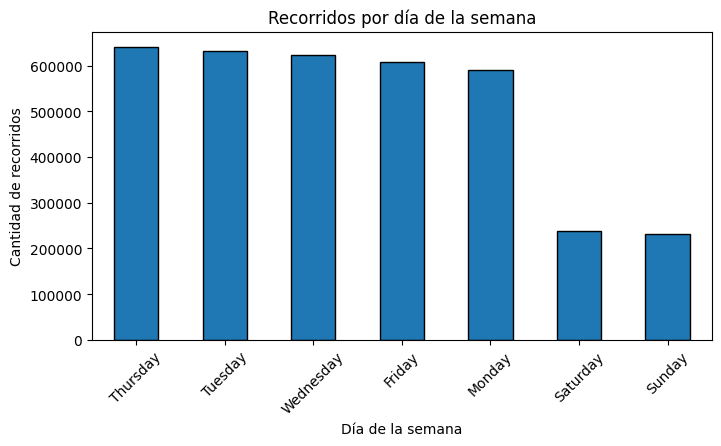

In [44]:
# Bar chart de recorridos por dia de la semana
plt.figure(figsize=(8, 4))
rides_df['dia_semana_origen_recorrido'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

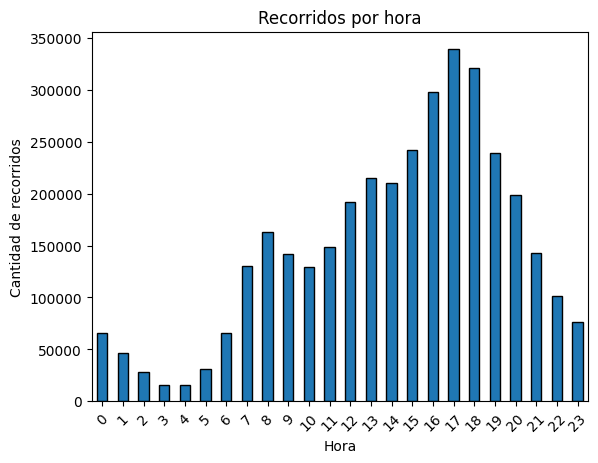

In [45]:
# Recorridos por hora
rides_df['hora_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'], format='%H:%M:%S', errors='coerce').dt.hour
rides_df['hora_origen_recorrido'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

##### Exploración de estaciones

In [46]:
# Estaciones más usadas para iniciar recorridos
origin_top_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=False).head(5)
print(origin_top_stations)

nombre_estacion_origen
147 - Constitución           38284
014 - Pacifico               37594
368 - PLAZA DE LA SHOÁ       37201
005 - Plaza Italia           34547
001 - FACULTAD DE DERECHO    30955
Name: count, dtype: int64


In [47]:
# Estaciones más usadas para terminar recorridos
destination_top_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=False).head(5)
print(destination_top_stations)

nombre_estacion_destino
147 - Constitución           38363
368 - PLAZA DE LA SHOÁ       37425
014 - Pacifico               37278
005 - Plaza Italia           34607
001 - FACULTAD DE DERECHO    30897
Name: count, dtype: int64


In [48]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Origenes
cols_ori = ['nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']
coords = (rides_df[rides_df['nombre_estacion_origen'].isin(origin_top_stations.index)]
          [cols_ori].dropna().drop_duplicates('nombre_estacion_origen'))

for _, r in coords.iterrows():
    nombre, lat, lon = r['nombre_estacion_origen'], float(r['lat_estacion_origen']), float(r['long_estacion_origen'])
    
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='green', icon='play', prefix='fa')).add_to(m)
    
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_orig.html')

In [49]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Destinos
cols_dest = ['nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']
coords_dest = (rides_df[rides_df['nombre_estacion_destino'].isin(destination_top_stations.index)]
               [cols_dest].dropna().drop_duplicates('nombre_estacion_destino'))

for _, r in coords_dest.iterrows():
    nombre, lat, lon = r['nombre_estacion_destino'], float(r['lat_estacion_destino']), float(r['long_estacion_destino'])
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='red', icon='flag-checkered', prefix='fa')).add_to(m)
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_dest.html')

In [50]:
# Estaciones menos usadas para iniciar recorridos
origin_bottom_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=True).head(5)
print(origin_bottom_stations)

nombre_estacion_origen
040 - HERRERA    258
125 - BILBAO     268
327 - IBERA      331
321 - EZEIZA     360
326 - PICO       385
Name: count, dtype: int64


In [51]:
# Estaciones menos usadas para terminar recorridos
destination_bottom_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=True).head(5)
print(destination_bottom_stations)

nombre_estacion_destino
-- CDO Chacarita -- (Temporal)      2
363 - Udaondo                       9
291 - REPARACION DE K7             11
125 - BILBAO                      272
040 - HERRERA                     283
Name: count, dtype: int64


##### Exploración de usuarios de recorridos

In [52]:
rides_df['id_usuario'] = rides_df['id_usuario'].astype('Int64')

In [53]:
# Usuario que más recorridos hizo
top_user = rides_df['id_usuario'].value_counts().idxmax()
print(f"Usuario que más recorridos hizo: ID {top_user} con {rides_df['id_usuario'].value_counts().max()} recorridos")

Usuario que más recorridos hizo: ID 844251 con 8488 recorridos


##### Exploración de modelo de bicicleta
No aporta información significativa

In [54]:
rides_df['modelo_bicicleta'].value_counts()

modelo_bicicleta
FIT       2583213
ICONIC     977191
Name: count, dtype: int64

##### Exploración de géneros (en recorridos, algunos no tienen género asociado)

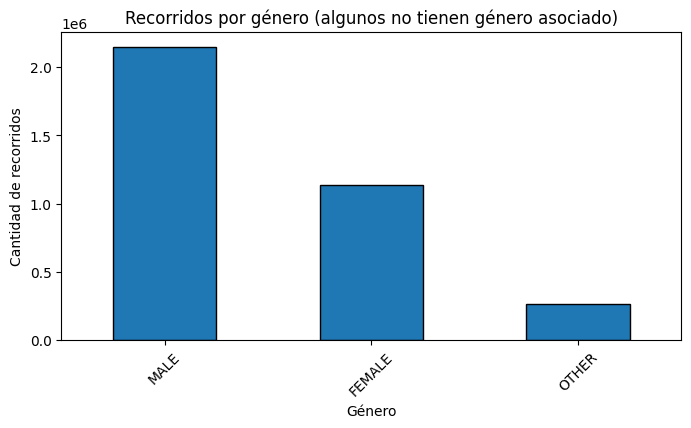

In [55]:
# Bar chart de recorridos por genero
plt.figure(figsize=(8, 4))
rides_df['genero'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por género (algunos no tienen género asociado)')
plt.xlabel('Género')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

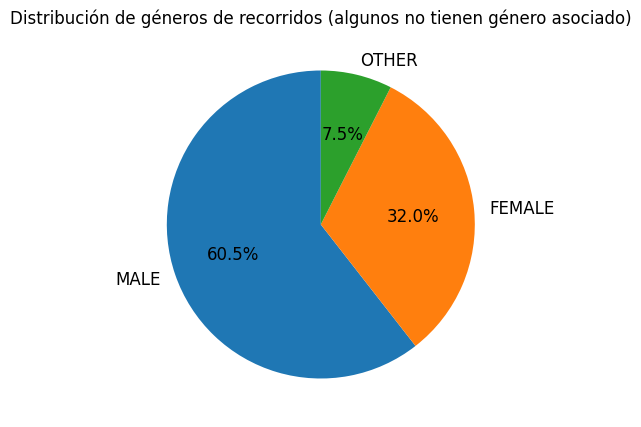

In [56]:
# Pie chart de generos de los recorridos (algunos recorridos no tienen género asociado)
plt.figure(figsize=(5, 5))
rides_df['genero'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de recorridos (algunos no tienen género asociado)')
plt.ylabel('')
plt.show()

### Merge datasets usuarios + recorridos?

In [57]:
# Cuántos usuarios de rides_df están en users_df?
np.isin(rides_df['id_usuario'], users_df['id_usuario']).sum()

np.int64(1136610)

No resulta útil unir ambos datasets, ya que más de un millón de recorridos no tienen `id_usuario` asociado.<br>
Esto se debe a que el dataset de usuarios 2024 solo incluye altas realizadas en ese año, mientras que el dataset de recorridos 2024 también contiene viajes de usuarios que se registraron en años anteriores.<br>
<br>
**Por eso se van a tratar ambos datasets de forma separada.**

# Split de los datasets

### Estrategia de partición para el dataset de recorridos

Se realiza un **split aleatorio** en lugar de un split temporal, por las siguientes razones:
- Datos únicamente de 2024 (un solo año)
- Existe fuerte estacionalidad intra-anual (más viajes en primavera/verano, menos en invierno)
- No se cuenta con datos históricos de años anteriores o posteriores

**Justificación del split aleatorio:**
1. **Evita sesgo estacional**: Un split temporal (por ej.: 80% primeros meses → 20% últimos meses) haría que train y test tengan distribuciones estacionales diferentes, sesgando la evaluación.

2. **Representatividad**: El shuffle garantiza que tanto train como test contengan datos de todas las estaciones del año, manteniendo la distribución temporal.

3. **No hay generalización temporal**: Como solo tenemos un año, no podemos evaluar predicción hacia el futuro (2025 en adelante). El objetivo en este dataset es evaluar la capacidad de generalización del modelo sobre patrones intra-anuales, no sobre datos futuros desconocidos.

<br>

**Nota: Si en el futuro se incorporan datos de múltiples años, sería apropiado usar un split temporal (entrenar con años 2022-2023, testear con 2024) para evaluar capacidad predictiva sobre el futuro, y evitando data leakage.**

In [58]:
TEST_PROPORTION = 0.2  # 20% para test
RANDOM_SEED = 25

In [59]:
users_df_train, users_df_test = train_test_split(users_df,
                                                 test_size=TEST_PROPORTION,
                                                 shuffle=True,
                                                 random_state=RANDOM_SEED)

In [60]:
rides_df_train, rides_df_test = train_test_split(rides_df,
                                                 test_size=TEST_PROPORTION,
                                                 random_state=RANDOM_SEED)

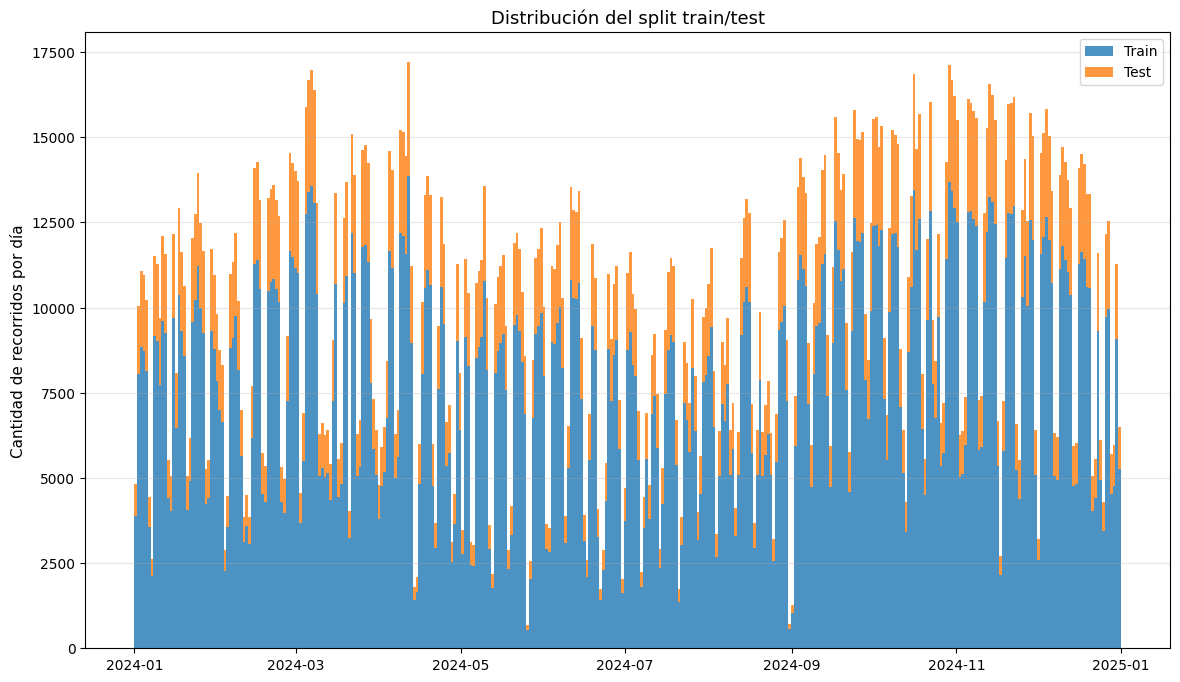

In [61]:
# Verificación del split
fig, ax = plt.subplots(figsize=(14, 8))

ax.hist([rides_df_train['fecha_origen_recorrido'], rides_df_test['fecha_origen_recorrido']], 
         bins=365,  # Un bin por día
         stacked=True,
         label=['Train', 'Test'],
         color=['#1f77b4', '#ff7f0e'],
         alpha=0.8,
         edgecolor='none')

ax.set_ylabel('Cantidad de recorridos por día', fontsize=11)
ax.set_title('Distribución del split train/test', 
              fontsize=13)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.show()

# Análisis y tratamiento de faltantes

### Usuarios

In [62]:
users_df_train.isna().sum()

id_usuario        0
genero_usuario    0
edad_usuario      0
fecha_alta        0
hora_alta         0
fecha_alta_dt     0
hora_alta_dt      0
dia_semana        0
dtype: int64

In [63]:
users_df_train.dia_semana.unique()  # Check que los días sean datos válidos

array(['Saturday', 'Tuesday', 'Wednesday', 'Friday', 'Sunday', 'Monday',
       'Thursday'], dtype=object)

In [64]:
users_df_train.genero_usuario.unique()  # Check que los géneros sean datos válidos

array(['FEMALE', 'MALE', 'OTHER'], dtype=object)

In [65]:
users_df_train['fecha_alta_dt'].dt.year.unique()  # Check que los años sean datos válidos

array([2024], dtype=int32)

**No hay datos faltantes en el dataset de usuarios**

### Recorridos

In [66]:
rides_df_train.isna().sum()

id_recorrido                      0
duracion_recorrido                0
fecha_origen_recorrido            0
id_estacion_origen                0
nombre_estacion_origen            0
direccion_estacion_origen         0
long_estacion_origen              0
lat_estacion_origen               0
fecha_destino_recorrido        2700
id_estacion_destino               0
nombre_estacion_destino           0
direccion_estacion_destino        0
long_estacion_destino             0
lat_estacion_destino              0
id_usuario                        0
modelo_bicicleta                  0
genero                         9543
duracion_recorrido_min            0
mes                               0
dia_semana_origen_recorrido       0
hora_origen_recorrido             0
dtype: int64

In [67]:
mask_duration_zero = rides_df_train["duracion_recorrido"] == 0
print(f"Recorridos con duración 0: {mask_duration_zero.sum()}")

mask_origin_neq_destination = rides_df_train["id_estacion_origen"] != rides_df_train["id_estacion_destino"]
mask_origin_eq_destination = rides_df_train["id_estacion_origen"] == rides_df_train["id_estacion_destino"]

mask_duration_zero_and_origin_neq_destination = mask_duration_zero & mask_origin_neq_destination
mask_duration_zero_and_origin_eq_destination = mask_duration_zero & mask_origin_eq_destination

print(f"Recorridos con duración 0 y origen distinto a destino: {mask_duration_zero_and_origin_neq_destination.sum()}")
print(f"Recorridos con duración 0 y origen igual a destino: {mask_duration_zero_and_origin_eq_destination.sum()}")

mask_duration_zero_and_origin_eq_destination_and_same_date = mask_duration_zero_and_origin_eq_destination & (rides_df_train["fecha_origen_recorrido"] == rides_df_train["fecha_destino_recorrido"])
mask_duration_zero_and_origin_eq_destination_and_different_date = mask_duration_zero_and_origin_eq_destination & (rides_df_train["fecha_origen_recorrido"] != rides_df_train["fecha_destino_recorrido"])
print(f"Recorridos con duración 0, origen igual a destino y misma fecha de origen y destino: {mask_duration_zero_and_origin_eq_destination_and_same_date.sum()}")
print(f"Recorridos con duración 0, origen igual a destino y distinta fecha de origen y destino: {mask_duration_zero_and_origin_eq_destination_and_different_date.sum()}")

Recorridos con duración 0: 30149
Recorridos con duración 0 y origen distinto a destino: 25156
Recorridos con duración 0 y origen igual a destino: 4993
Recorridos con duración 0, origen igual a destino y misma fecha de origen y destino: 4928
Recorridos con duración 0, origen igual a destino y distinta fecha de origen y destino: 65


**Podemos considerar que los siguientes registros de duración de recorridos son faltantes:**
- **Duración 0 y origen distinto a destino**: la bicicleta se movió de estación, el tiempo de viaje no puede ser 0
- **Duración 0 y origen igual a destino, pero distinta fecha de origen que destino**: la bicicleta viajó y volvió a la misma estación, el tiempo de viaje no puede ser 0

In [68]:
rides_df_train[mask_duration_zero_and_origin_neq_destination]["mes"].value_counts().sort_index()

mes
1     1157
2     2230
3     2436
4     2036
5     1788
6     1475
7     1285
8     1609
9     2283
10    2114
11    2918
12    3825
Name: count, dtype: int64

In [69]:
print(f"Proporción de recorridos con duración 0 y origen distinto a destino: {mask_duration_zero_and_origin_neq_destination.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con duración 0 y origen distinto a destino: 0.883 %


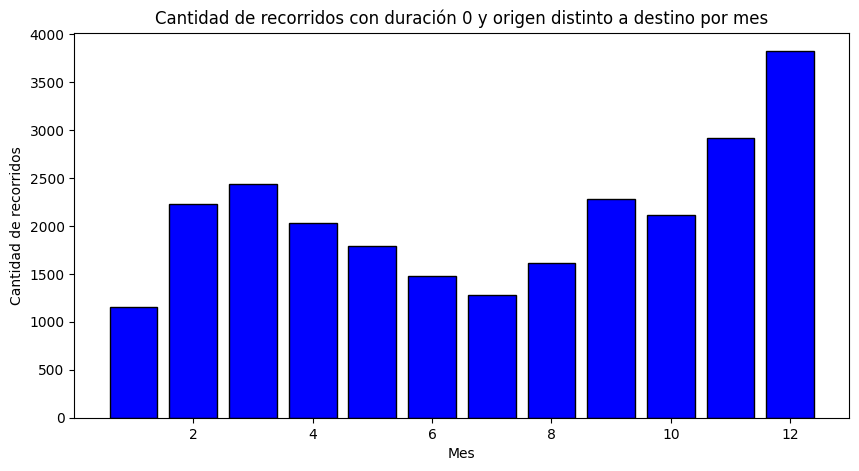

In [70]:
# Bar chart de cantidad de recorridos con duración 0 y origen distinto a destino por mes
plt.figure(figsize=(10, 5))
month_counts = rides_df_train[mask_duration_zero_and_origin_neq_destination]['mes'].value_counts().sort_index()
plt.bar(month_counts.index, month_counts.values, color='blue', edgecolor='black')
plt.title('Cantidad de recorridos con duración 0 y origen distinto a destino por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de recorridos')
plt.show()

**Los recorridos con duración 0 y origen distinto a destino, no se distribuyen con un patrón específico sino que siguen el comportamiento del número de recorridos totales por mes, con lo cual parece que estos registros faltan de forma completamente aleatoria (MCAR).**

In [71]:
rides_df_train[mask_duration_zero_and_origin_eq_destination_and_different_date]["mes"].value_counts().sort_index()

mes
11    25
12    40
Name: count, dtype: int64

In [72]:
print(f"Proporción de recorridos con duración 0 y origen igual a destino y distinta fecha de origen que destino: {mask_duration_zero_and_origin_eq_destination_and_different_date.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con duración 0 y origen igual a destino y distinta fecha de origen que destino: 0.002 %


**Los recorridos con duración 0, origen igual a destino pero distinta fecha de origen que destino no se distribuyen de forma random, sino que solo se dan en noviembre y diciembre, probablemente estén relacionados con los faltantes que están más adelante en este análisis.**

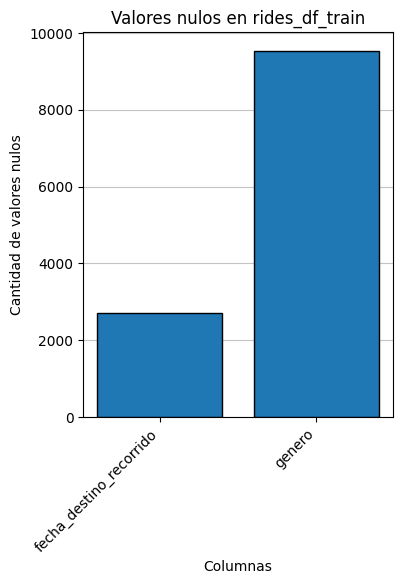

In [73]:
cols = ["fecha_destino_recorrido", "genero"]

plt.figure(figsize=(4, 5))
plt.grid(axis='y', alpha=0.75)
plt.bar(cols, rides_df_train[cols].isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df_train')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

##### Faltantes de fecha_destino_recorrido

In [74]:
mask_date_na = rides_df_train["fecha_destino_recorrido"].isna()
rides_df_train[mask_date_na].head(5)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido
923079,24181455,0,2024-12-05 17:55:10,449,352 - San Jose de Flores,Av. Rivadavia 6955,-58.463297,-34.628836,NaN,509,386 - VELEZ SARSFIELD,Av. Carrasco 214,-58.489810,-34.633638,67340,ICONIC,MALE,0.0,12,Thursday,17
452438,24362617,0,2024-12-18 21:13:51,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,NaN,474,224 - BAIGORRIA,Baigorria 4101,-58.503020,-34.610892,709592,ICONIC,MALE,0.0,12,Wednesday,21
1073307,24231281,0,2024-12-09 20:31:15,61,098 - BENITO JUAREZ,Benito Juarez 2231,-58.505177,-34.618927,NaN,197,197 - PLAZA CIUDAD DE UDINE,Mercedes 1480,-58.493044,-34.620998,1197740,FIT,FEMALE,0.0,12,Monday,20
1708802,24002555,0,2024-11-22 21:16:05,118,118 - MEXICO,Saavedra & Mexico,-58.402653,-34.617020,NaN,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,1049513,FIT,MALE,0.0,11,Friday,21
722927,24282718,0,2024-12-12 22:20:04,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,NaN,449,352 - San Jose de Flores,Av. Rivadavia 6955,-58.463297,-34.628836,751098,FIT,MALE,0.0,12,Thursday,22


In [75]:
rides_df_train[mask_date_na]["mes"].value_counts().sort_index()

mes
11     911
12    1789
Name: count, dtype: int64

**Indicios de que el sistema funcionó mal en algunos dias de noviembre y diciembre.**

In [76]:
print(f"Proporción de recorridos con fecha destino nula: {mask_date_na.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con fecha destino nula: 0.095 %


In [77]:
mask_nov = rides_df_train["mes"] == 11
mask_dec = rides_df_train["mes"] == 12
mask_nov_dec = mask_nov | mask_dec
mask_nov_na = mask_nov & mask_date_na
mask_dec_na = mask_dec & mask_date_na

In [78]:
rides_df_train[mask_nov_na]

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido
1708802,24002555,0,2024-11-22 21:16:05,118,118 - MEXICO,Saavedra & Mexico,-58.402653,-34.617020,NaN,183,183 - VIRREY CEVALLOS,Mexico 1652,-58.389973,-34.615699,1049513,FIT,MALE,0.0,11,Friday,21
1790058,24002606,0,2024-11-22 21:20:10,208,145 - RAVIGNANI,EMILIO RAVIGNANI 1802,-58.438404,-34.580716,NaN,99,099 - Malabia,780 Malabia & Loyola,-58.435408,-34.596096,1224704,FIT,MALE,0.0,11,Friday,21
1827770,24031179,0,2024-11-25 19:43:09,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,NaN,281,350 - Plaza Irlanda,Av. Gaona 2200,-58.458315,-34.613778,1162255,FIT,FEMALE,0.0,11,Monday,19
1659379,24050491,0,2024-11-26 21:53:56,65,065 - Julián Álvarez,3822 Guemes,-58.415787,-34.587312,NaN,242,103 - MALBA,Av. Pres. Figueroa Alcorta 3451,-58.403984,-34.576949,998977,ICONIC,FEMALE,0.0,11,Tuesday,21
2807471,23779551,0,2024-11-07 20:26:25,329,100 - Plaza Gurruchaga,Gurruchaga 1084,-58.435066,-34.593110,NaN,291,244 - UADE,Lima 750,-58.381627,-34.617247,1021892,FIT,MALE,0.0,11,Thursday,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457363,24102163,0,2024-11-29 22:16:15,163,163 - ONCE II,Bartolome Mitre & Av. Puyrredon,-58.406431,-34.609566,NaN,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,816666,FIT,OTHER,0.0,11,Friday,22
1805173,24049208,0,2024-11-26 20:19:34,476,279 - PLAZA MONTE CASTRO,Gualeguaychú 1900,-58.498525,-34.618292,NaN,455,039 - Plaza Don Bosco,Elpidio Gonzalez 5181,-58.508050,-34.626520,596530,FIT,OTHER,0.0,11,Tuesday,20
1818433,24010944,0,2024-11-23 23:40:26,543,139 - CASA ROSADA,Av. Alicia Moreau de Justo 861,-58.366741,-34.607480,NaN,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1113786,FIT,FEMALE,0.0,11,Saturday,23
1553177,24101483,0,2024-11-29 21:11:11,9,009 - Parque Las Heras,"2300 Diaz, Cnel. Av. & French",-58.407741,-34.585443,NaN,50,050 - Hospital Rivadavia,2516 Pereyra Lucena,-58.401080,-34.583735,1162316,FIT,MALE,0.0,11,Friday,21


In [79]:
mask_duration_zero_and_nov_na = mask_nov_na & mask_duration_zero
print(f"Recorridos en noviembre con duración 0 y fecha destino nula: {mask_duration_zero_and_nov_na.sum()}")

mask_duration_zero_and_dec_na = mask_dec_na & mask_duration_zero
print(f"Recorridos en diciembre con duración 0 y fecha destino nula: {mask_duration_zero_and_dec_na.sum()}")

Recorridos en noviembre con duración 0 y fecha destino nula: 911
Recorridos en diciembre con duración 0 y fecha destino nula: 1789


**Se observa que todos los registros faltantes de `fecha_destino_recorrido` también tienen duración 0**

In [80]:
pd.to_datetime(rides_df_train["fecha_origen_recorrido"], errors='coerce').dt.year.unique()  # Check que los años sean datos válidos

array([2024], dtype=int32)

In [81]:
pd.to_datetime(rides_df_train['fecha_destino_recorrido'], errors='coerce').dt.year.unique()  # Check que los años sean datos válidos

array([2024.,   nan, 2025.])

##### Faltantes de genero

In [82]:
mask_gen_na = rides_df_train["genero"].isna()
print(f"Recorridos con género faltante: {mask_gen_na.sum()}")

Recorridos con género faltante: 9543


In [83]:
print(f"Proporción de recorridos con género faltante: {mask_gen_na.sum() / len(rides_df_train) * 100:.3f} %")

Proporción de recorridos con género faltante: 0.335 %


In [84]:
rides_df_train[mask_gen_na]["mes"].value_counts().sort_index()

mes
1     778
2     671
3     853
4     756
5     861
6     723
7     720
8     765
9     871
10    912
11    830
12    803
Name: count, dtype: int64

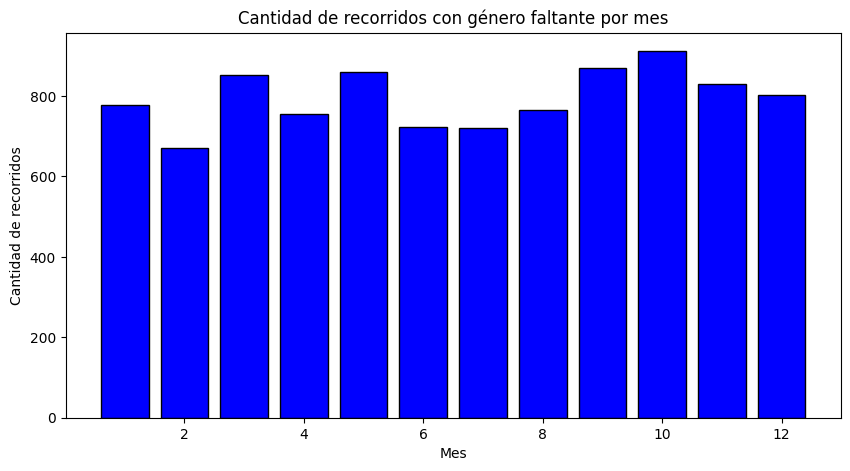

In [85]:
# Bar chart de cantidad de recorridos con género faltante por mes
plt.figure(figsize=(10, 5))
month_counts = rides_df_train[mask_gen_na]['mes'].value_counts().sort_index()
plt.bar(month_counts.index, month_counts.values, color='blue', edgecolor='black')
plt.title('Cantidad de recorridos con género faltante por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de recorridos')
plt.show()

**Los recorridos con género faltante, no se distribuyen con un patrón específico sino que siguen el comportamiento del número de recorridos totales por mes, con lo cual parece que estos registros faltan de forma completamente aleatoria (MCAR).**

### Estrategias para tratamiento de faltantes
- Recorridos con duración 0 y origen distinto a destino faltan de forma completamente aleatoria (MCAR) y representan un 0.88 % de los registros de training -> **Aplicamos eliminación de fila**
<br>
<br>
- Recorridos con duración 0 y origen igual a destino y distinta fecha de origen que destino no son MCAR, pero igualmente representan un 0.002 % -> **Aplicamos eliminación de fila**
<br>
<br>
- Recorridos con fecha destino nula no son MCAR, pero igualmente representan un 0.095 % de los registros de training -> **Aplicamos eliminación de fila**
<br>
<br>
- Recorridos sin género faltan de forma completamente aleatoria (MCAR) y representan un 0.335 % de los registros de training -> **Aplicamos eliminación de fila**

In [86]:
# No se eliminan datos en users_df_train
users_df_train_cleaned = users_df_train.copy()

In [87]:
mask_for_deletion = mask_duration_zero_and_origin_neq_destination | mask_duration_zero_and_origin_eq_destination_and_different_date | mask_date_na | mask_gen_na
print(f"Total de recorridos a eliminar: {mask_for_deletion.sum()} ({mask_for_deletion.sum() / len(rides_df_train) * 100:.3f} % del total)")
rides_df_train_cleaned = rides_df_train[~mask_for_deletion].copy()
rides_df_train_cleaned.reset_index(drop=True, inplace=True)

Total de recorridos a eliminar: 34680 (1.218 % del total)


# Análisis y tratamiento de outliers

### Usuarios

Se vio Más arriba en la etapa exploratoria que `edad_usuario` contiene muchos valores atípicos, incluso algunos por encima de los 1000 años.<br>
Probablemente se debió a un error al ingresar el dato en el sistema, al momento del alta de usuario.<br>
Los términos y condiciones del sistema contemplan usuarios con edad mínima 16 años.

In [88]:
# Edades < 16
mask_age_lt_16 = users_df_train_cleaned["edad_usuario"] < 16
print(f"Usuarios con edad < 16: {mask_age_lt_16.sum()} ({mask_age_lt_16.sum() / len(users_df_train_cleaned) * 100:.3f} % del total)")
users_df_train_cleaned[mask_age_lt_16]

Usuarios con edad < 16: 8 (0.005 % del total)


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta,fecha_alta_dt,hora_alta_dt,dia_semana
157229,1087178,MALE,15,2024-01-05,23:09:04,2024-01-05,23:09:04,Friday
132348,1257721,OTHER,5,2024-11-24,14:02:31,2024-11-24,14:02:31,Sunday
116314,1225229,MALE,5,2024-10-09,11:42:12,2024-10-09,11:42:12,Wednesday
94405,1083783,MALE,4,2024-01-01,12:05:43,2024-01-01,12:05:43,Monday
73194,1138759,MALE,5,2024-04-02,08:47:40,2024-04-02,08:47:40,Tuesday
124842,1192893,MALE,15,2024-08-16,00:07:41,2024-08-16,00:07:41,Friday
44659,1200706,MALE,4,2024-09-04,19:32:10,2024-09-04,19:32:10,Wednesday
49179,1216711,OTHER,5,2024-09-28,10:55:52,2024-09-28,10:55:52,Saturday


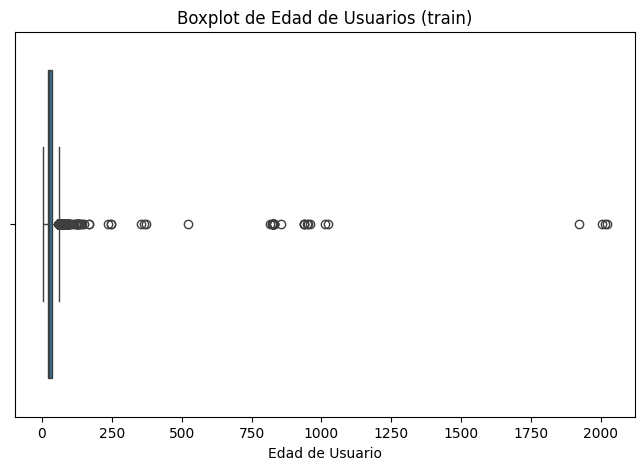

Outliers en edad_usuario: 2663 (1.689 % del total)
Valores de outliers: 2021 (máximo), 62 (mínimo)
Conteo de valores de outliers:
62: 368
63: 309
64: 249
65: 220
66: 184
67: 182
68: 153
71: 119
69: 111
72: 105
70: 98
73: 78
75: 66
74: 59
77: 50
76: 49
78: 40
79: 32
80: 29
83: 18
81: 18
82: 15
84: 10
86: 9
85: 9
88: 5
89: 5
90: 4
93: 4
87: 4
828: 4
91: 4
830: 3
938: 3
102: 2
124: 2
123: 2
92: 2
247: 2
129: 2
960: 1
827: 1
825: 1
2004: 1
236: 1
815: 1
139: 1
98: 1
2016: 1
829: 1
952: 1
353: 1
94: 1
138: 1
127: 1
373: 1
855: 1
824: 1
1012: 1
107: 1
170: 1
168: 1
149: 1
367: 1
113: 1
96: 1
948: 1
524: 1
142: 1
128: 1
2021: 1
826: 1
131: 1
1022: 1
1921: 1


In [89]:
# Detectar outliers en edad_usuario usando método de IQR
Q1 = users_df_train_cleaned['edad_usuario'].quantile(0.25)
Q3 = users_df_train_cleaned['edad_usuario'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (users_df_train_cleaned['edad_usuario'] < lower_bound) | (users_df_train_cleaned['edad_usuario'] > upper_bound)
outliers = users_df_train_cleaned[outliers_mask]

plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df_train_cleaned['edad_usuario'])
plt.title('Boxplot de Edad de Usuarios (train)')
plt.xlabel('Edad de Usuario')
plt.show()

print(f"Outliers en edad_usuario: {outliers.shape[0]} ({outliers.shape[0] / users_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers: {outliers['edad_usuario'].max()} (máximo), {outliers['edad_usuario'].min()} (mínimo)")
print(f"Conteo de valores de outliers:")
for valor, cantidad in outliers['edad_usuario'].value_counts().items():
    print(f"{valor}: {cantidad}")

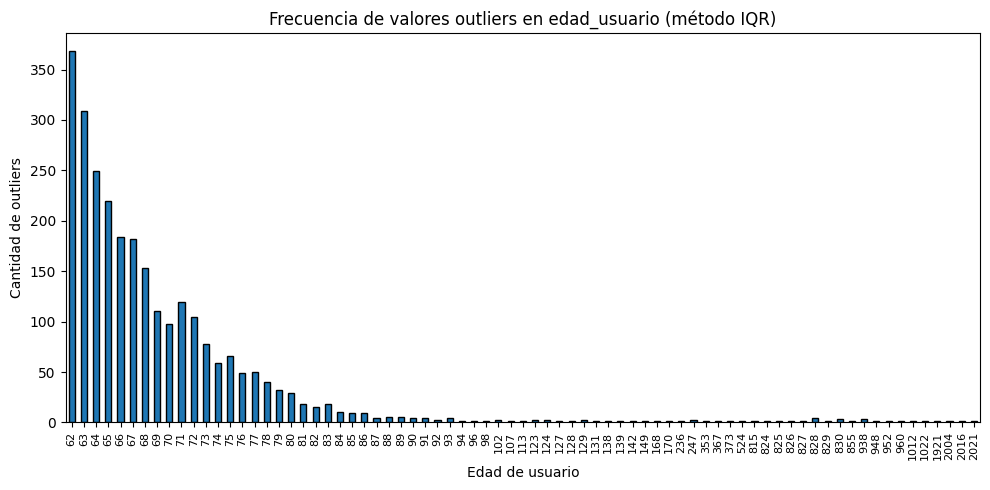

In [90]:
plt.figure(figsize=(10, 5))
outliers['edad_usuario'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Frecuencia de valores outliers en edad_usuario (método IQR)')
plt.xlabel('Edad de usuario')
plt.ylabel('Cantidad de outliers')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

El método de IQR parece tomar valores perfectamente posibles (62 a 98) como outliers.<br>
Esto se debe a que este método funciona mejor para distribuciones relativamente simétricas, y `edad_usuario` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [153]:
# Outliers en edad_usuario usando método de desvio estandar (Z-score)
z_scores = np.abs(stats.zscore(users_df_train_cleaned['edad_usuario']))
z_threshold = 3  # Umbral típico
outliers_z = users_df_train_cleaned[z_scores > z_threshold]
print(f"Outliers detectados en edad_usuario por Z-score: {outliers_z.shape[0]} ({outliers_z.shape[0] / users_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers por Z-score: {outliers_z['edad_usuario'].max()} (máximo), {outliers_z['edad_usuario'].min()} (mínimo)")
outliers_z['edad_usuario'].value_counts().sort_index()

Outliers detectados en edad_usuario por Z-score: 92 (0.058 % del total)
Valores de outliers por Z-score: 2021 (máximo), 86 (mínimo)


edad_usuario
86      9
87      4
88      5
89      5
90      4
91      4
92      2
93      4
94      1
96      1
98      1
102     2
107     1
113     1
123     2
124     2
127     1
128     1
129     2
131     1
138     1
139     1
142     1
149     1
168     1
170     1
236     1
247     2
353     1
367     1
373     1
524     1
815     1
824     1
825     1
826     1
827     1
828     4
829     1
830     3
855     1
938     3
948     1
952     1
960     1
1012    1
1022    1
1921    1
2004    1
2016    1
2021    1
Name: count, dtype: int64

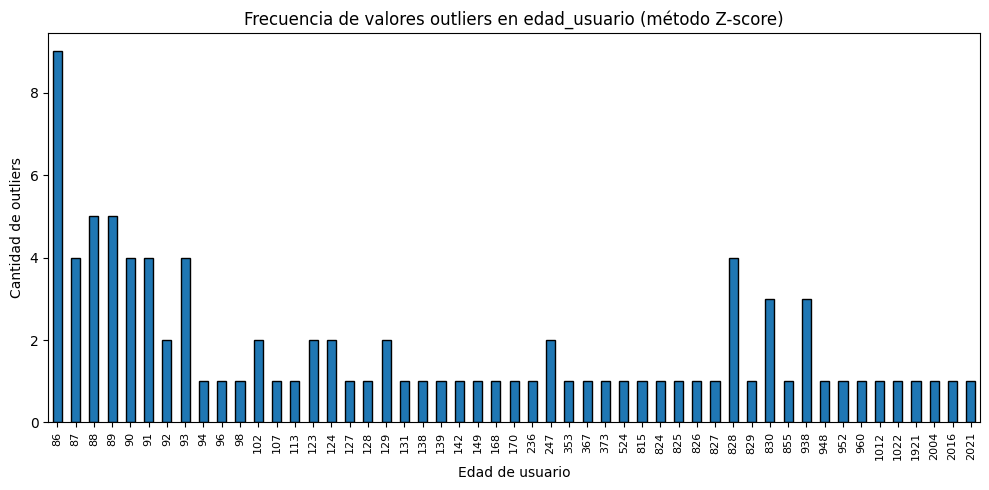

In [92]:
# Plot de outliers detectados por Z-score
plt.figure(figsize=(10, 5))
outliers_z['edad_usuario'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Frecuencia de valores outliers en edad_usuario (método Z-score)')
plt.xlabel('Edad de usuario')
plt.ylabel('Cantidad de outliers')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

El método de desvio estandar (Z-score) parece funcionar mejor que el método de IQR, pero igualmente funciona mejor para distribuciones relativamente simétricas, y `edad_usuario` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [93]:
# Winsorización de edades en users
def winsorize_by_quantiles(series, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower=lower_bound, upper=upper_bound)

def winsorize_by_values(series, lower_value=16, upper_value=100):
    return series.clip(lower=lower_value, upper=upper_value)

users_df_train_cleaned['edad_usuario_winsorized'] = winsorize_by_values(users_df_train_cleaned['edad_usuario'])
print("Edades después de winsorización:")
print(users_df_train_cleaned['edad_usuario_winsorized'].describe().apply(lambda x: f"{x:,.2f}"))

Edades después de winsorización:
count    157,663.00
mean          30.59
std           11.66
min           16.00
25%           21.00
50%           27.00
75%           37.00
max          100.00
Name: edad_usuario_winsorized, dtype: object


In [94]:
users_df_train_cleaned['edad_usuario_winsorized'].value_counts().sort_index()

edad_usuario_winsorized
16        14
17        13
18     11996
19     10566
20      9221
       ...  
93         4
94         1
96         1
98         1
100       52
Name: count, Length: 82, dtype: int64

El método de winsorización genera una gran cantidad de valores en el 'tope' superior de los datos, sesgando el análisis.

In [95]:
# Reemplazo de valores con edad mayor a 100 y menores a 16 por la mediana
median_age = users_df_train_cleaned['edad_usuario'].median()
users_df_train_cleaned['edad_usuario_cleaned_median'] = users_df_train_cleaned['edad_usuario'].apply(lambda x: median_age if x > 100 or x < 16 else x)
print("Edades después de reemplazo de valores > 100 y < 16 por la mediana:")
print(users_df_train_cleaned['edad_usuario_cleaned_median'].describe())

Edades después de reemplazo de valores > 100 y < 16 por la mediana:
count    157663.000000
mean         30.568669
std          11.588608
min          16.000000
25%          21.000000
50%          27.000000
75%          37.000000
max          98.000000
Name: edad_usuario_cleaned_median, dtype: float64


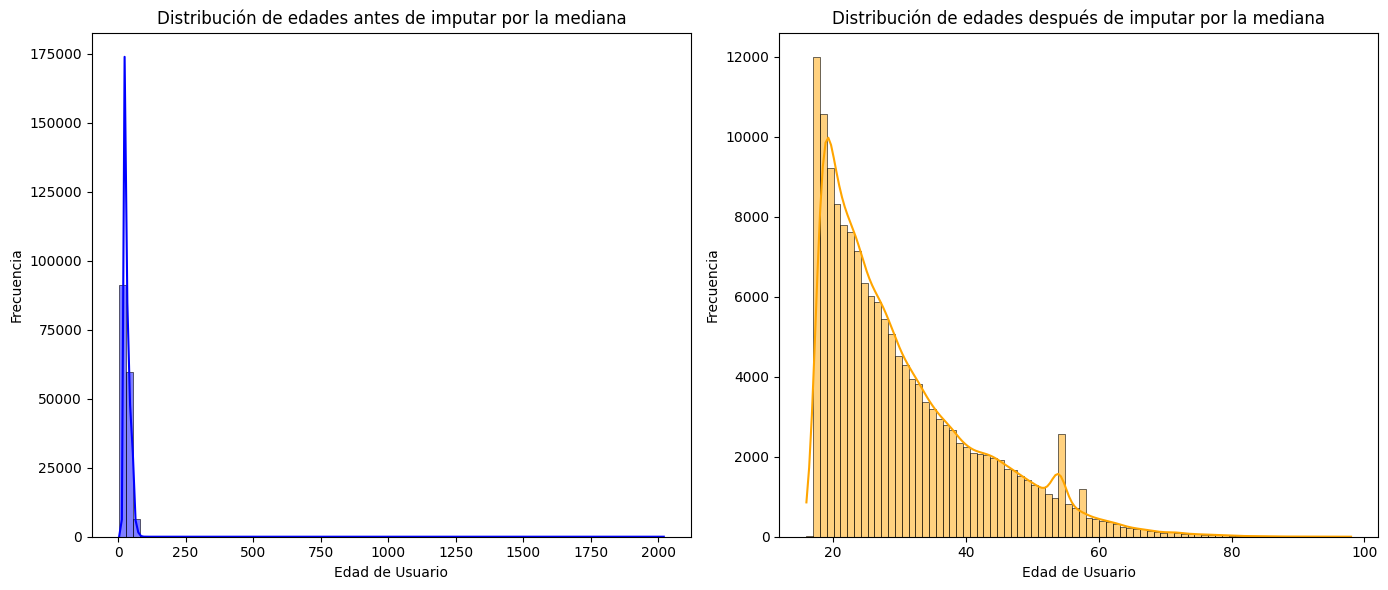

In [96]:
# Bar chart de edades antes y después de imputar edades >100 por la mediana
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(users_df_train_cleaned['edad_usuario'], bins=80, kde=True, color='blue')
plt.title('Distribución de edades antes de imputar por la mediana')
plt.xlabel('Edad de Usuario')
plt.ylabel('Frecuencia')
plt.subplot(1, 2, 2)
sns.histplot(users_df_train_cleaned['edad_usuario_cleaned_median'], bins=80, kde=True, color='orange')
plt.title('Distribución de edades después de imputar por la mediana')
plt.xlabel('Edad de Usuario')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

#### Estrategia para el tratamiento de outliers en `edad_usuario`
Se decidió entender la lógica de negocio y basado en los siguientes criterios, se imputaron:
- Los valores menores a 16 por la mediana (TyC de Ecobici no contempla menores de 16 años)
- Los valores mayores a 100 por la mediana
<br>
<br>
**Se imputó por la mediana, dado que `edad_usuario` tiene una distribución con sesgo positivo y la media resulta muy sensible ante valores extremos.**

In [97]:
# Limpieza final, quitamos las columnas que no se usan
if 'edad_usuario_winsorized' in users_df_train_cleaned.columns:
    users_df_train_cleaned.drop(columns=['edad_usuario_winsorized'], inplace=True)

### Recorridos

Se vio Más arriba en la etapa exploratoria que `duracion_recorrido` contiene muchos valores atípicos, incluso algunos por encima de los 40.000 minutos (~28 dias).<br>
Probablemente los valores altamente atípicos se debieron a bicicletas que no fueron devueltas (robadas) o a errores del sistema.

In [98]:
# Detectar outliers en duracion_recorrido usando método de IQR
Q1 = rides_df_train_cleaned['duracion_recorrido_min'].quantile(0.25)
Q3 = rides_df_train_cleaned['duracion_recorrido_min'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = rides_df_train_cleaned[(rides_df_train_cleaned['duracion_recorrido_min'] < lower_bound) | (rides_df_train_cleaned['duracion_recorrido_min'] > upper_bound)]

print(f"Outliers en duracion_recorrido (min): {outliers.shape[0]} ({outliers.shape[0] / rides_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers (min): {outliers['duracion_recorrido_min'].max()} (máximo), {outliers['duracion_recorrido_min'].min()} (mínimo)")
print(f"Conteo de valores de outliers:")
for valor, cantidad in outliers['duracion_recorrido_min'].value_counts().sort_index().items():
    print(f"{valor:.2f}: {cantidad}")

Outliers en duracion_recorrido (min): 157561 (5.600 % del total)
Valores de outliers (min): 42852.75 (máximo), 49.166666666666664 (mínimo)
Conteo de valores de outliers:
49.17: 126
49.18: 130
49.20: 137
49.22: 132
49.23: 148
49.25: 133
49.27: 127
49.28: 126
49.30: 130
49.32: 117
49.33: 120
49.35: 124
49.37: 132
49.38: 121
49.40: 130
49.42: 106
49.43: 118
49.45: 145
49.47: 127
49.48: 122
49.50: 124
49.52: 125
49.53: 132
49.55: 117
49.57: 131
49.58: 126
49.60: 121
49.62: 134
49.63: 114
49.65: 129
49.67: 136
49.68: 135
49.70: 122
49.72: 114
49.73: 139
49.75: 132
49.77: 118
49.78: 132
49.80: 123
49.82: 119
49.83: 117
49.85: 139
49.87: 146
49.88: 114
49.90: 116
49.92: 117
49.93: 143
49.95: 145
49.97: 130
49.98: 123
50.00: 135
50.02: 109
50.03: 134
50.05: 107
50.07: 105
50.08: 123
50.10: 98
50.12: 126
50.13: 144
50.15: 106
50.17: 120
50.18: 137
50.20: 130
50.22: 116
50.23: 126
50.25: 150
50.27: 139
50.28: 117
50.30: 112
50.32: 111
50.33: 111
50.35: 130
50.37: 141
50.38: 114
50.40: 116
50.42:

El método de IQR parece tomar valores perfectamente posibles (~49 min en adelante) como outliers.<br>
Incluso cambiando el factor multiplicador del IQR para hacerlo menos restrictivo sigue siendo demasiado acotado.<br>
Esto se debe a que este método funciona mejor para distribuciones relativamente simétricas, y `duracion_recorrido` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [99]:
# Outliers en duracion_recorrido usando método de desvio estandar (Z-score)
z_scores = np.abs(stats.zscore(rides_df_train_cleaned['duracion_recorrido_min']))
z_threshold = 3  # Umbral típico
outliers_z = rides_df_train_cleaned[z_scores > z_threshold]

print(f"Outliers detectados en duracion_recorrido (min) por Z-score: {outliers_z.shape[0]} ({outliers_z.shape[0] / rides_df_train_cleaned.shape[0] * 100:.3f} % del total)")
print(f"Valores de outliers (min) usando Z-score: {outliers_z['duracion_recorrido_min'].max()} (máximo), {outliers_z['duracion_recorrido_min'].min()} (mínimo)")
print(f"\nConteo de valores de outliers por Z-score:")
for valor, cantidad in outliers_z['duracion_recorrido_min'].value_counts().sort_index().items():
    print(f"{valor:.2f}: {cantidad}")

Outliers detectados en duracion_recorrido (min) por Z-score: 1907 (0.068 % del total)
Valores de outliers (min) usando Z-score: 42852.75 (máximo), 507.9166666666667 (mínimo)

Conteo de valores de outliers por Z-score:
507.92: 1
508.28: 1
508.35: 1
508.38: 1
508.63: 1
508.97: 1
509.05: 1
509.45: 1
509.58: 1
510.13: 1
510.35: 1
510.62: 1
510.80: 1
510.95: 1
511.08: 1
511.10: 1
511.12: 1
511.15: 1
511.20: 2
511.23: 1
511.32: 1
512.00: 1
512.05: 1
512.85: 1
513.27: 1
513.32: 1
513.45: 1
513.52: 1
513.53: 1
514.10: 1
514.12: 1
514.58: 1
515.05: 1
515.25: 1
515.32: 1
515.45: 1
515.65: 1
515.70: 1
516.02: 1
516.03: 1
516.28: 1
516.32: 1
516.38: 1
516.53: 1
516.72: 1
517.48: 1
517.60: 1
518.42: 1
518.52: 1
518.60: 1
518.82: 1
519.17: 1
519.93: 1
520.18: 1
520.28: 1
520.37: 1
521.07: 1
522.02: 1
522.08: 1
522.10: 1
522.13: 1
522.65: 1
522.72: 1
523.27: 1
523.37: 1
523.78: 1
523.98: 1
524.30: 2
524.52: 1
524.55: 1
524.58: 1
524.63: 1
524.75: 1
524.83: 1
524.85: 1
525.00: 1
525.08: 1
525.10: 1
52

El método de desvio estandar (Z-score) parece funcionar mejor que el método de IQR, pero igualmente funciona mejor para distribuciones relativamente simétricas, y `duracion_recorrido` no lo es, es una distribución asimétrica con cola pesada a derecha.

In [100]:
# Winsorización de duracion_recorrido en recorridos
rides_df_train_cleaned['duracion_recorrido_min_winsorized'] = winsorize_by_quantiles(rides_df_train_cleaned['duracion_recorrido_min'], lower_quantile=0.001, upper_quantile=0.9995)
print("Duración de recorridos (min) después de winsorización:")
print(rides_df_train_cleaned['duracion_recorrido_min_winsorized'].describe().apply(lambda x: f"{x:,.2f}"))
winsorized = rides_df_train_cleaned[rides_df_train_cleaned['duracion_recorrido_min'] != rides_df_train_cleaned['duracion_recorrido_min_winsorized']]
print(f"\nRegistros winsorizados: {winsorized.shape[0]} ({winsorized.shape[0] / rides_df_train_cleaned.shape[0] * 100:.3f} % del total)")

Duración de recorridos (min) después de winsorización:
count    2,813,643.00
mean            20.02
std             27.25
min              0.00
25%              8.37
50%             14.82
75%             24.68
max            643.99
Name: duracion_recorrido_min_winsorized, dtype: object

Registros winsorizados: 1407 (0.050 % del total)


# Feature engineering

Agregamos una feature derivada (si una fecha cae en feriado) cruzando con los datos de feriados Argentina 2024.<br>
Dicha columna se agrega a los conjuntos train y test dado que "feriado" no depende de ninguna información futura ni de la variable objetivo, es simplemente una transformación determinística de la fecha de cada recorrido, por ese motivo no hay data leakage.

In [101]:
import holidays

feriados_ar = holidays.Argentina(years=[2024])

In [102]:
# Indica si la fecha de origen del recorrido es feriado
rides_df_train_cleaned['feriado'] = rides_df_train_cleaned['fecha_origen_recorrido'].dt.date.isin(feriados_ar)
rides_df_test['feriado'] = rides_df_test['fecha_origen_recorrido'].dt.date.isin(feriados_ar)

In [103]:
# Verificación de feriados
mask_holiday = rides_df_train_cleaned['feriado'] == True
rides_df_train_cleaned[mask_holiday].sample(10)


,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,duracion_recorrido_min,mes,dia_semana_origen_recorrido,hora_origen_recorrido,duracion_recorrido_min_winsorized,feriado
1483719,23398619,535,2024-10-11 13:10:33,169,169 - FACULTAD DE PSICOLOGIA,Av. Hipólito Yrigoyen 3417,-58.414971,-34.613071,2024-10-11 13:19:28,96,096 - Carlos Gardel,3302 Guardia Vieja & Aguero,-58.411659,-34.602781,963325,FIT,FEMALE,8.916667,10,Friday,13,8.916667,True
2464559,21143899,3888,2024-03-24 19:20:18,171,171 - Pasteur,519 Pasteur,-58.399755,-34.603281,2024-03-24 20:25:06,461,106 - MOSCONI Y CONSTITUYENTES,CONSTITUYENTES 4710,-58.493630,-34.580880,279453,FIT,MALE,64.800000,3,Sunday,19,64.800000,True
388058,23402788,21,2024-10-11 18:54:54,498,055 - HABANA,Gral. José Gervasio Artigas 4298 (y Habana),-58.494959,-34.586598,2024-10-11 18:55:15,498,055 - HABANA,Gral. José Gervasio Artigas 4298 (y Habana),-58.494959,-34.586598,881324,FIT,MALE,0.350000,10,Friday,18,0.350000,True
264354,23405172,1539,2024-10-12 05:34:02,46,046 - Chile,Perú 718,-58.374370,-34.616373,2024-10-12 05:59:41,184,184 - Pedro Echague,Pedro Echague 1878 & Combate De Los Pozos,-58.391342,-34.630613,511993,FIT,OTHER,25.650000,10,Saturday,5,25.650000,True
2783809,21199211,990,2024-03-28 12:07:31,480,353 - PLAZA VÉLEZ SARSFIELD,Chivilcoy 400,-58.483603,-34.629334,2024-03-28 12:24:01,473,216 - EMILIO LAMARCA,EMILIO LAMARCA 2066,-58.493358,-34.613403,448366,FIT,FEMALE,16.500000,3,Thursday,12,16.500000,True
1474226,20183929,4144,2024-01-01 16:55:25,516,368 - PLAZA DE LA SHOÁ,Av. Del Libertador 3899,-58.423347,-34.570998,2024-01-01 18:04:29,260,371 - Paseo de las Americas,Av. Pres Figueroa Alcorta 6400,-58.435223,-34.553079,1083890,ICONIC,OTHER,69.066667,1,Monday,16,69.066667,True
388533,20635224,2008,2024-02-12 20:36:46,429,201 - PLAZA EJERCITO DE LOS ANDES,Av. Rivadavia y Albariño,-58.510102,-34.638974,2024-02-12 21:10:14,255,374 - Puan,Yerbal 1290,-58.448547,-34.622092,960163,FIT,FEMALE,33.466667,2,Monday,20,33.466667,True
2366632,20181985,1067,2024-01-01 07:28:27,167,275 - PLAZA 24 DE SEPTIEMBRE,1355 San Martin Av.,-58.448540,-34.606984,2024-01-01 07:46:14,281,350 - Plaza Irlanda,Av. Gaona 2200,-58.458315,-34.613778,98469,FIT,MALE,17.783333,1,Monday,7,17.783333,True
815095,21238442,648,2024-04-02 08:28:14,289,255 - BARRANCAS DE BELGRANO,"Sucre, Antonio Jose De, Mcal. Y Vertiz Virrey Av.",-58.448314,-34.559801,2024-04-02 08:39:02,379,390 - De Los Ombues,Av. de los Ombúes 300,-58.428100,-34.560200,564438,FIT,OTHER,10.800000,4,Tuesday,8,10.800000,True
1246459,21206395,917,2024-03-28 21:50:55,200,200 - AUSTRIA Y FRENCH,Austria 2075,-58.404261,-34.588300,2024-03-28 22:06:12,467,328 - SARMIENTO II,Sarmiento 2037,-58.395893,-34.605514,113038,ICONIC,FEMALE,15.283333,3,Thursday,21,15.283333,True


=== ANÁLISIS: DISTANCIA VS USO DE ESTACIONES ===
Número de pares de estaciones analizados: 86388
Rango de distancias: 0.004 - 18.319 km
Rango de uso promedio: 280 - 29885 viajes


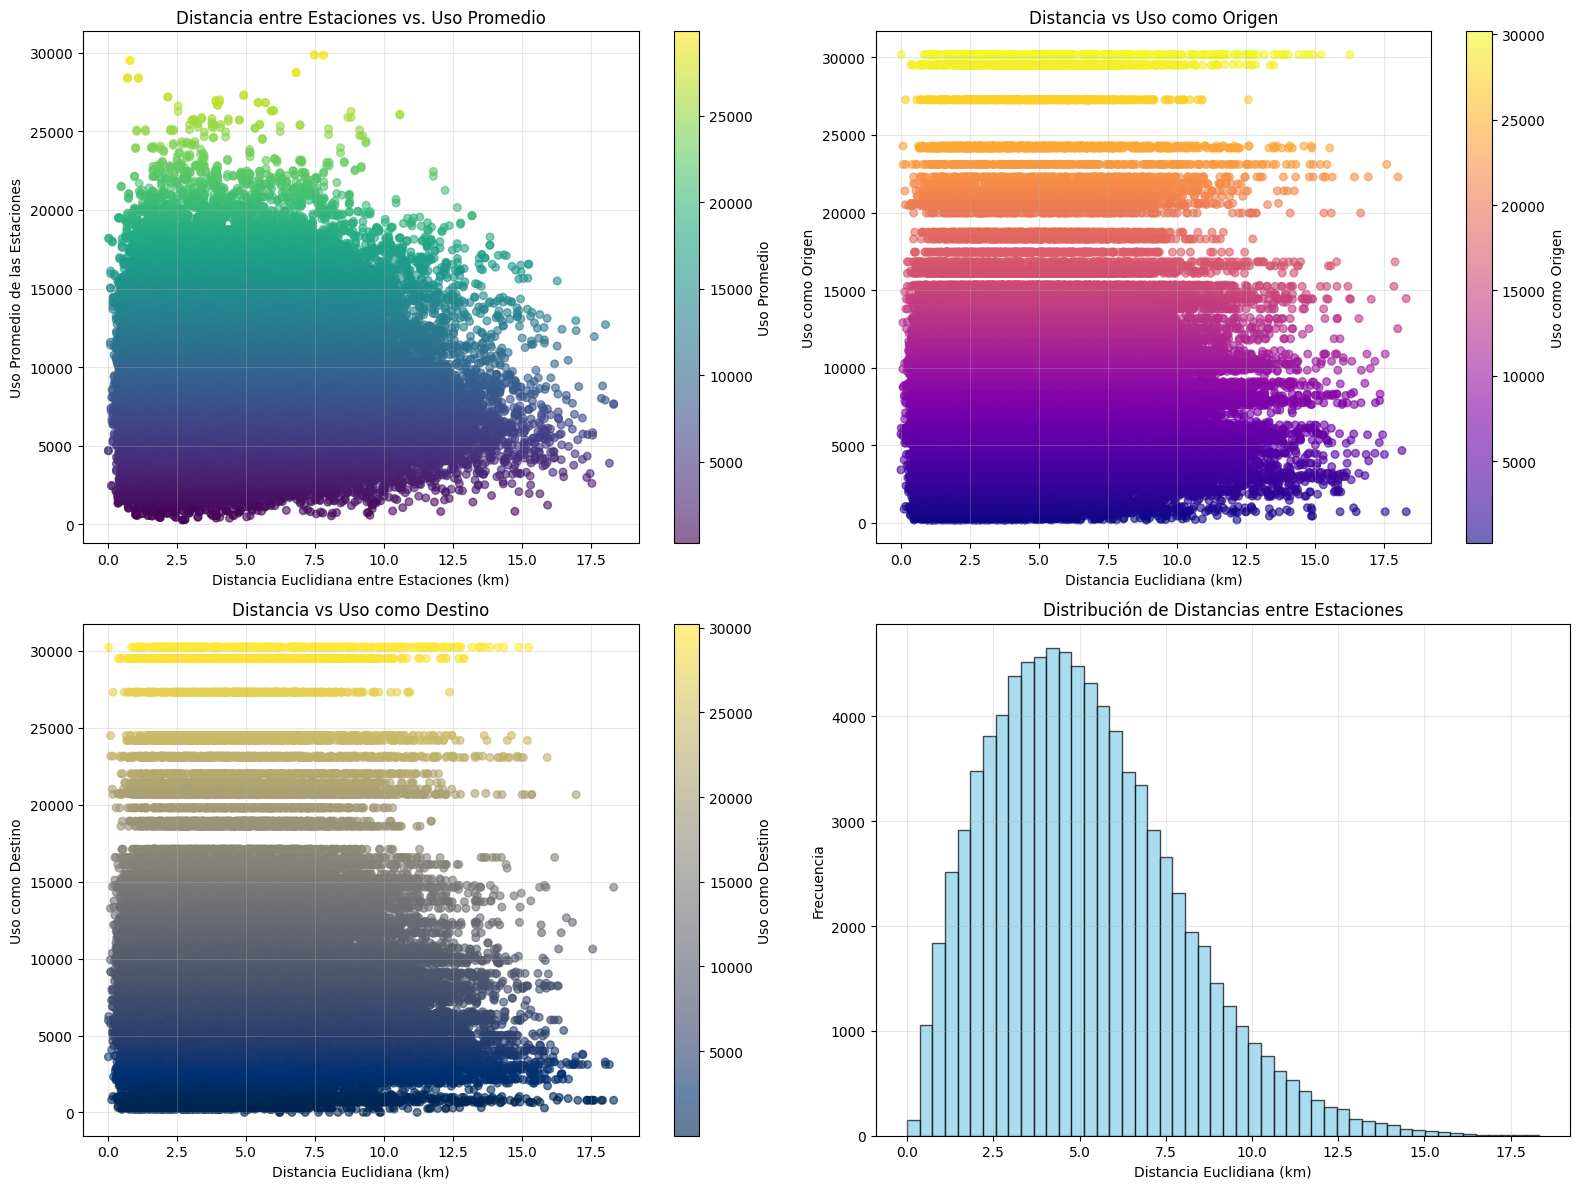


=== ANÁLISIS DE CORRELACIÓN ===
Correlación entre distancia y uso promedio: 0.025

=== TOP 10 PARES DE ESTACIONES MÁS UTILIZADOS ===
014 - Pacifico → 147 - Constitución
  Distancia: 7.471 km, Uso promedio: 29885 viajes

368 - PLAZA DE LA SHOÁ → 147 - Constitución
  Distancia: 7.800 km, Uso promedio: 29862 viajes

147 - Constitución → 368 - PLAZA DE LA SHOÁ
  Distancia: 7.800 km, Uso promedio: 29839 viajes

147 - Constitución → 014 - Pacifico
  Distancia: 7.471 km, Uso promedio: 29833 viajes

014 - Pacifico → 368 - PLAZA DE LA SHOÁ
  Distancia: 0.789 km, Uso promedio: 29518 viajes

368 - PLAZA DE LA SHOÁ → 014 - Pacifico
  Distancia: 0.789 km, Uso promedio: 29489 viajes

005 - Plaza Italia → 147 - Constitución
  Distancia: 6.810 km, Uso promedio: 28750 viajes

147 - Constitución → 005 - Plaza Italia
  Distancia: 6.810 km, Uso promedio: 28742 viajes

014 - Pacifico → 005 - Plaza Italia
  Distancia: 0.696 km, Uso promedio: 28421 viajes

368 - PLAZA DE LA SHOÁ → 005 - Plaza Italia
  Dista

In [104]:
# 1. Distancia euclidiana entre estaciones
rides_df_train_cleaned['distancia_km'] = np.sqrt(
    (rides_df_train_cleaned['long_estacion_destino'] - rides_df_train_cleaned['long_estacion_origen'])**2 + 
    (rides_df_train_cleaned['lat_estacion_destino'] - rides_df_train_cleaned['lat_estacion_origen'])**2
) * 111  # Aproximación: 1 grado = 111 km

# Gráfico: Distancia euclidiana entre estaciones vs. uso de esas estaciones
print("=== ANÁLISIS: DISTANCIA VS USO DE ESTACIONES ===")

# Calcular el uso de cada estación como origen y destino
uso_origen = rides_df_train_cleaned['nombre_estacion_origen'].value_counts().rename('uso_origen')
uso_destino = rides_df_train_cleaned['nombre_estacion_destino'].value_counts().rename('uso_destino')

# Crear DataFrame de pares de estaciones con su distancia promedio
pares_estaciones = rides_df_train_cleaned.groupby(['nombre_estacion_origen', 'nombre_estacion_destino']).agg({
    'distancia_km': 'mean'
}).reset_index()

# Filtrar solo pares de estaciones diferentes (origen ≠ destino)
pares_estaciones = pares_estaciones[pares_estaciones['nombre_estacion_origen'] != pares_estaciones['nombre_estacion_destino']]

# Agregar el uso de cada estación al DataFrame de pares
pares_estaciones = pares_estaciones.merge(uso_origen, left_on='nombre_estacion_origen', right_index=True, how='left')
pares_estaciones = pares_estaciones.merge(uso_destino, left_on='nombre_estacion_destino', right_index=True, how='left')

# Calcular el uso promedio entre origen y destino
pares_estaciones['uso_promedio'] = pares_estaciones[['uso_origen', 'uso_destino']].mean(axis=1)

print(f"Número de pares de estaciones analizados: {len(pares_estaciones)}")
print(f"Rango de distancias: {pares_estaciones['distancia_km'].min():.3f} - {pares_estaciones['distancia_km'].max():.3f} km")
print(f"Rango de uso promedio: {pares_estaciones['uso_promedio'].min():.0f} - {pares_estaciones['uso_promedio'].max():.0f} viajes")

# Crear visualización con múltiples gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Scatter plot principal - Distancia vs Uso Promedio
scatter = axes[0,0].scatter(pares_estaciones['distancia_km'], pares_estaciones['uso_promedio'], 
                           alpha=0.6, s=30, c=pares_estaciones['uso_promedio'], cmap='viridis')
axes[0,0].set_xlabel('Distancia Euclidiana entre Estaciones (km)')
axes[0,0].set_ylabel('Uso Promedio de las Estaciones')
axes[0,0].set_title('Distancia entre Estaciones vs. Uso Promedio')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0,0], label='Uso Promedio')

# Gráfico 2: Distancia vs Uso como Origen
scatter2 = axes[0,1].scatter(pares_estaciones['distancia_km'], pares_estaciones['uso_origen'], 
                            alpha=0.6, s=30, c=pares_estaciones['uso_origen'], cmap='plasma')
axes[0,1].set_xlabel('Distancia Euclidiana (km)')
axes[0,1].set_ylabel('Uso como Origen')
axes[0,1].set_title('Distancia vs Uso como Origen')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0,1], label='Uso como Origen')

# Gráfico 3: Distancia vs Uso como Destino
scatter3 = axes[1,0].scatter(pares_estaciones['distancia_km'], pares_estaciones['uso_destino'], 
                            alpha=0.6, s=30, c=pares_estaciones['uso_destino'], cmap='cividis')
axes[1,0].set_xlabel('Distancia Euclidiana (km)')
axes[1,0].set_ylabel('Uso como Destino')
axes[1,0].set_title('Distancia vs Uso como Destino')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1,0], label='Uso como Destino')

# Gráfico 4: Histograma de distancias
axes[1,1].hist(pares_estaciones['distancia_km'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].set_xlabel('Distancia Euclidiana (km)')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title('Distribución de Distancias entre Estaciones')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlación
correlacion = pares_estaciones['distancia_km'].corr(pares_estaciones['uso_promedio'])
print(f"\n=== ANÁLISIS DE CORRELACIÓN ===")
print(f"Correlación entre distancia y uso promedio: {correlacion:.3f}")

# Top 10 pares de estaciones más utilizados
top_pares = pares_estaciones.nlargest(10, 'uso_promedio')[['nombre_estacion_origen', 'nombre_estacion_destino', 'distancia_km', 'uso_promedio']]
print(f"\n=== TOP 10 PARES DE ESTACIONES MÁS UTILIZADOS ===")
for idx, row in top_pares.iterrows():
    print(f"{row['nombre_estacion_origen']} → {row['nombre_estacion_destino']}")
    print(f"  Distancia: {row['distancia_km']:.3f} km, Uso promedio: {row['uso_promedio']:.0f} viajes\n")

### Creacion de variable objetivo: Demanda de bicicletas por estación de origen

In [124]:
# Creación de variable objetivo: demanda de bicicletas por estación
# Agrupamos por: día, estación de ORIGEN y rango horario (1 hora)
# Esto representa cuántas bicicletas se toman de cada estación en cada momento

# 1. Extraer la hora del timestamp de origen
rides_df_train_cleaned['hora_origen'] = rides_df_train_cleaned['fecha_origen_recorrido'].dt.hour

# 2. Extraer la fecha (sin hora) del timestamp de origen
rides_df_train_cleaned['fecha_origen'] = rides_df_train_cleaned['fecha_origen_recorrido'].dt.date

# 3. Crear la variable objetivo: contar viajes por (fecha, estación_ORIGEN, hora)
demanda_por_estacion = (rides_df_train_cleaned
                       .groupby(['fecha_origen', 'nombre_estacion_origen', 'hora_origen'])
                       .size()
                       .reset_index(name='demanda_bicicletas'))

# 4. Convertir fecha_origen a datetime para extraer variables temporales
demanda_por_estacion['fecha_origen'] = pd.to_datetime(demanda_por_estacion['fecha_origen'])

# 5. Agregar variables temporales y derivadas
print("=== AGREGANDO VARIABLES TEMPORALES Y DERIVADAS ===")

# Variables temporales básicas
demanda_por_estacion['dia_semana'] = demanda_por_estacion['fecha_origen'].dt.day_name()
demanda_por_estacion['numero_dia_semana'] = demanda_por_estacion['fecha_origen'].dt.dayofweek  # 0=Lunes, 6=Domingo
demanda_por_estacion['mes'] = demanda_por_estacion['fecha_origen'].dt.month
demanda_por_estacion['dia_del_mes'] = demanda_por_estacion['fecha_origen'].dt.day
demanda_por_estacion['semana_del_año'] = demanda_por_estacion['fecha_origen'].dt.isocalendar().week
demanda_por_estacion['trimestre'] = demanda_por_estacion['fecha_origen'].dt.quarter

# Variables derivadas
demanda_por_estacion['es_fin_de_semana'] = demanda_por_estacion['numero_dia_semana'].isin([5, 6])  # Sábado y Domingo
demanda_por_estacion['es_feriado'] = demanda_por_estacion['fecha_origen'].dt.date.isin(feriados_ar)

# Estación del año
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:  # [9, 10, 11]
        return 'Primavera'

demanda_por_estacion['estacion_año'] = demanda_por_estacion['mes'].apply(obtener_estacion)

# Categorización horaria
def categorizar_hora(hora):
    if 5 <= hora <= 11:
        return 'Mañana'
    elif 12 <= hora <= 17:
        return 'Tarde'  
    elif 18 <= hora <= 23:
        return 'Noche'
    else:  # 0-4
        return 'Madrugada'

demanda_por_estacion['periodo_dia'] = demanda_por_estacion['hora_origen'].apply(categorizar_hora)

# Horarios pico
def es_hora_pico(hora, es_fin_semana):
    if es_fin_semana:
        # Fin de semana: picos más suaves en la tarde
        return hora in [15, 16, 17, 18, 19, 20]
    else:
        # Días laborales: picos mañana y tarde
        return hora in [7, 8, 9, 17, 18, 19]

demanda_por_estacion['es_hora_pico'] = demanda_por_estacion.apply(
    lambda row: es_hora_pico(row['hora_origen'], row['es_fin_de_semana']), axis=1
)

# Día laboral vs no laboral (considerando feriados)
demanda_por_estacion['es_dia_laboral'] = ~(demanda_por_estacion['es_fin_de_semana'] | demanda_por_estacion['es_feriado'])

# Variables cíclicas para hora (útiles para modelos de ML)
demanda_por_estacion['hora_sin'] = np.sin(2 * np.pi * demanda_por_estacion['hora_origen'] / 24)
demanda_por_estacion['hora_cos'] = np.cos(2 * np.pi * demanda_por_estacion['hora_origen'] / 24)

# Variables cíclicas para día de la semana
demanda_por_estacion['dia_semana_sin'] = np.sin(2 * np.pi * demanda_por_estacion['numero_dia_semana'] / 7)
demanda_por_estacion['dia_semana_cos'] = np.cos(2 * np.pi * demanda_por_estacion['numero_dia_semana'] / 7)

# Variables cíclicas para mes
demanda_por_estacion['mes_sin'] = np.sin(2 * np.pi * demanda_por_estacion['mes'] / 12)
demanda_por_estacion['mes_cos'] = np.cos(2 * np.pi * demanda_por_estacion['mes'] / 12)

# Variables cíclicas para día del mes
demanda_por_estacion['dia_del_mes_sin'] = np.sin(2 * np.pi * demanda_por_estacion['dia_del_mes'] / 31)
demanda_por_estacion['dia_del_mes_cos'] = np.cos(2 * np.pi * demanda_por_estacion['dia_del_mes'] / 31)

# Variables cíclicas para semana del año
demanda_por_estacion['semana_del_año_sin'] = np.sin(2 * np.pi * demanda_por_estacion['semana_del_año'] / 52)
demanda_por_estacion['semana_del_año_cos'] = np.cos(2 * np.pi * demanda_por_estacion['semana_del_año'] / 52)

# Variables cíclicas para trimestre
demanda_por_estacion['trimestre_sin'] = np.sin(2 * np.pi * demanda_por_estacion['trimestre'] / 4)
demanda_por_estacion['trimestre_cos'] = np.cos(2 * np.pi * demanda_por_estacion['trimestre'] / 4)

print(f"Shape del dataset de demanda: {demanda_por_estacion.shape}")
print(f"Rango de demanda: {demanda_por_estacion['demanda_bicicletas'].min()} - {demanda_por_estacion['demanda_bicicletas'].max()} bicicletas")
print(f"Demanda promedio por estación-hora: {demanda_por_estacion['demanda_bicicletas'].mean():.2f} bicicletas")
print(f"Número de estaciones únicas: {demanda_por_estacion['nombre_estacion_origen'].nunique()}")
print(f"Número de fechas únicas: {demanda_por_estacion['fecha_origen'].nunique()}")
print(f"Nuevas columnas agregadas: {len(demanda_por_estacion.columns) - 4}")

# Mostrar resumen de las nuevas variables
print(f"\n=== RESUMEN DE VARIABLES CREADAS ===")
nuevas_columnas = ['dia_semana', 'numero_dia_semana', 'mes', 'dia_del_mes', 'semana_del_año', 'trimestre',
                   'es_fin_de_semana', 'es_feriado', 'estacion_año', 'periodo_dia', 'es_hora_pico', 
                   'es_dia_laboral', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 
                   'mes_sin', 'mes_cos', 'dia_del_mes_sin', 'dia_del_mes_cos', 
                   'semana_del_año_sin', 'semana_del_año_cos', 'trimestre_sin', 'trimestre_cos']

for col in nuevas_columnas:
    if col in demanda_por_estacion.columns:
        if demanda_por_estacion[col].dtype == 'object' or demanda_por_estacion[col].dtype == 'bool':
            print(f"{col}: {demanda_por_estacion[col].value_counts().head(3).to_dict()}")
        else:
            print(f"{col}: rango [{demanda_por_estacion[col].min():.3f}, {demanda_por_estacion[col].max():.3f}]")

demanda_por_estacion.head(10)

=== AGREGANDO VARIABLES TEMPORALES Y DERIVADAS ===
Shape del dataset de demanda: (1229535, 28)
Rango de demanda: 1 - 41 bicicletas
Demanda promedio por estación-hora: 2.29 bicicletas
Número de estaciones únicas: 395
Número de fechas únicas: 366
Nuevas columnas agregadas: 24

=== RESUMEN DE VARIABLES CREADAS ===
dia_semana: {'Thursday': 210754, 'Tuesday': 207838, 'Friday': 205561}
numero_dia_semana: rango [0.000, 6.000]
mes: rango [1.000, 12.000]
dia_del_mes: rango [1.000, 31.000]
semana_del_año: rango [1.000, 52.000]
trimestre: rango [1.000, 4.000]
es_fin_de_semana: {False: 1027806, True: 201729}
es_feriado: {False: 1187150, True: 42385}
Shape del dataset de demanda: (1229535, 28)
Rango de demanda: 1 - 41 bicicletas
Demanda promedio por estación-hora: 2.29 bicicletas
Número de estaciones únicas: 395
Número de fechas únicas: 366
Nuevas columnas agregadas: 24

=== RESUMEN DE VARIABLES CREADAS ===
dia_semana: {'Thursday': 210754, 'Tuesday': 207838, 'Friday': 205561}
numero_dia_semana: ran

,fecha_origen,nombre_estacion_origen,hora_origen,demanda_bicicletas,dia_semana,numero_dia_semana,mes,dia_del_mes,semana_del_año,trimestre,es_fin_de_semana,es_feriado,estacion_año,periodo_dia,es_hora_pico,es_dia_laboral,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos,dia_del_mes_sin,dia_del_mes_cos,semana_del_año_sin,semana_del_año_cos,trimestre_sin,trimestre_cos
0,2024-01-01,001 - FACULTAD DE DERECHO,6,2,Monday,0,1,1,1,1,False,True,Verano,Mañana,False,False,1.000000,6.123234e-17,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
1,2024-01-01,001 - FACULTAD DE DERECHO,9,2,Monday,0,1,1,1,1,False,True,Verano,Mañana,True,False,0.707107,-7.071068e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
2,2024-01-01,001 - FACULTAD DE DERECHO,10,2,Monday,0,1,1,1,1,False,True,Verano,Mañana,False,False,0.500000,-8.660254e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
3,2024-01-01,001 - FACULTAD DE DERECHO,11,3,Monday,0,1,1,1,1,False,True,Verano,Mañana,False,False,0.258819,-9.659258e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
4,2024-01-01,001 - FACULTAD DE DERECHO,13,3,Monday,0,1,1,1,1,False,True,Verano,Tarde,False,False,-0.258819,-9.659258e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
5,2024-01-01,001 - FACULTAD DE DERECHO,14,3,Monday,0,1,1,1,1,False,True,Verano,Tarde,False,False,-0.500000,-8.660254e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
6,2024-01-01,001 - FACULTAD DE DERECHO,15,6,Monday,0,1,1,1,1,False,True,Verano,Tarde,False,False,-0.707107,-7.071068e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
7,2024-01-01,001 - FACULTAD DE DERECHO,16,10,Monday,0,1,1,1,1,False,True,Verano,Tarde,False,False,-0.866025,-5.000000e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
8,2024-01-01,001 - FACULTAD DE DERECHO,17,6,Monday,0,1,1,1,1,False,True,Verano,Tarde,True,False,-0.965926,-2.588190e-01,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17
9,2024-01-01,001 - FACULTAD DE DERECHO,18,13,Monday,0,1,1,1,1,False,True,Verano,Noche,True,False,-1.000000,-1.836970e-16,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17


=== ANÁLISIS DE VARIABLES TEMPORALES Y DERIVADAS ===


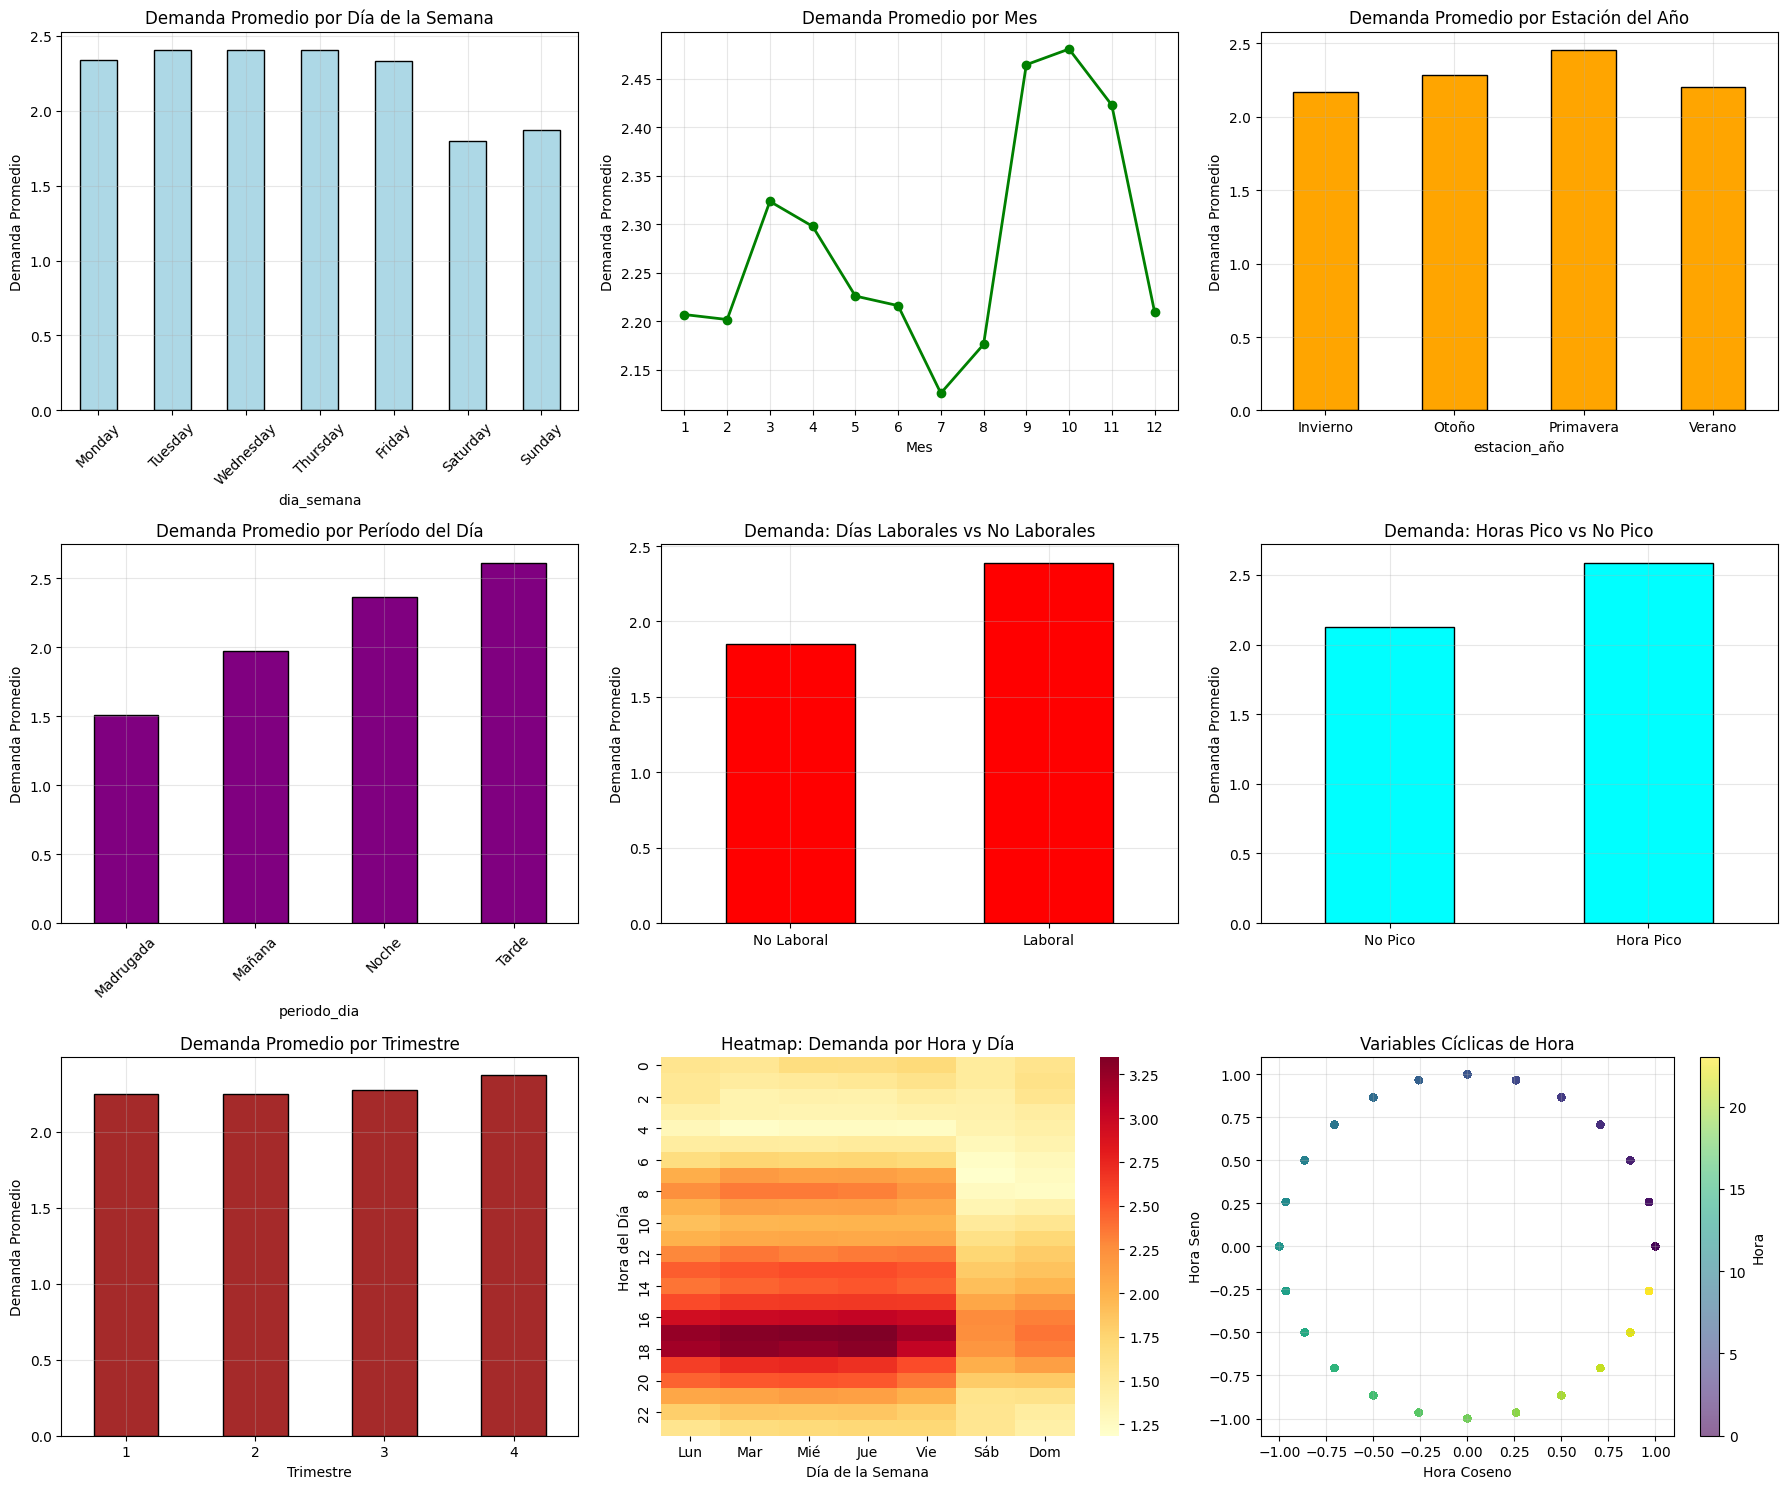


=== ESTADÍSTICAS RESUMIDAS ===
Distribución por tipo de día:
  - Días laborales: 80.9%
  - Fines de semana: 16.4%
  - Feriados: 3.4%
  - Horas pico: 35.2%

Demanda promedio por categoría:
  - Días laborales: 2.39
  - Días no laborales: 1.85
  - Horas pico: 2.59
  - Días no laborales: 1.85
  - Horas pico: 2.59
  - Horas no pico: 2.13

Dataset final:
  - Filas: 1,229,535
  - Columnas: 28
  - Variables temporales/derivadas: 18
  - Horas no pico: 2.13

Dataset final:
  - Filas: 1,229,535
  - Columnas: 28
  - Variables temporales/derivadas: 18


In [125]:
# Análisis de las variables temporales y derivadas creadas
print("=== ANÁLISIS DE VARIABLES TEMPORALES Y DERIVADAS ===")

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1. Demanda por día de la semana
demanda_por_dia_sem = demanda_por_estacion.groupby('dia_semana')['demanda_bicicletas'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
demanda_por_dia_sem.plot(kind='bar', ax=axes[0,0], color='lightblue', edgecolor='black')
axes[0,0].set_title('Demanda Promedio por Día de la Semana')
axes[0,0].set_ylabel('Demanda Promedio')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Demanda por mes
demanda_por_mes_nuevo = demanda_por_estacion.groupby('mes')['demanda_bicicletas'].mean()
demanda_por_mes_nuevo.plot(kind='line', ax=axes[0,1], color='green', marker='o', linewidth=2, markersize=6)
axes[0,1].set_title('Demanda Promedio por Mes')
axes[0,1].set_ylabel('Demanda Promedio')
axes[0,1].set_xlabel('Mes')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(1, 13))

# 3. Demanda por estación del año
demanda_por_estacion_nueva = demanda_por_estacion.groupby('estacion_año')['demanda_bicicletas'].mean()
demanda_por_estacion_nueva.plot(kind='bar', ax=axes[0,2], color='orange', edgecolor='black')
axes[0,2].set_title('Demanda Promedio por Estación del Año')
axes[0,2].set_ylabel('Demanda Promedio')
axes[0,2].tick_params(axis='x', rotation=0)
axes[0,2].grid(True, alpha=0.3)

# 4. Demanda por período del día
demanda_por_periodo = demanda_por_estacion.groupby('periodo_dia')['demanda_bicicletas'].mean()
demanda_por_periodo.plot(kind='bar', ax=axes[1,0], color='purple', edgecolor='black')
axes[1,0].set_title('Demanda Promedio por Período del Día')
axes[1,0].set_ylabel('Demanda Promedio')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 5. Comparación días laborales vs no laborales
demanda_laboral = demanda_por_estacion.groupby('es_dia_laboral')['demanda_bicicletas'].mean()
demanda_laboral.index = ['No Laboral', 'Laboral']
demanda_laboral.plot(kind='bar', ax=axes[1,1], color='red', edgecolor='black')
axes[1,1].set_title('Demanda: Días Laborales vs No Laborales')
axes[1,1].set_ylabel('Demanda Promedio')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].grid(True, alpha=0.3)

# 6. Demanda en horas pico vs no pico
demanda_pico = demanda_por_estacion.groupby('es_hora_pico')['demanda_bicicletas'].mean()
demanda_pico.index = ['No Pico', 'Hora Pico']
demanda_pico.plot(kind='bar', ax=axes[1,2], color='cyan', edgecolor='black')
axes[1,2].set_title('Demanda: Horas Pico vs No Pico')
axes[1,2].set_ylabel('Demanda Promedio')
axes[1,2].tick_params(axis='x', rotation=0)
axes[1,2].grid(True, alpha=0.3)

# 7. Demanda por trimestre
demanda_trimestre = demanda_por_estacion.groupby('trimestre')['demanda_bicicletas'].mean()
demanda_trimestre.plot(kind='bar', ax=axes[2,0], color='brown', edgecolor='black')
axes[2,0].set_title('Demanda Promedio por Trimestre')
axes[2,0].set_ylabel('Demanda Promedio')
axes[2,0].set_xlabel('Trimestre')
axes[2,0].tick_params(axis='x', rotation=0)
axes[2,0].grid(True, alpha=0.3)

# 8. Heatmap: Demanda por hora y día de la semana
pivot_demanda_nuevo = demanda_por_estacion.pivot_table(
    values='demanda_bicicletas', 
    index='hora_origen', 
    columns='numero_dia_semana', 
    aggfunc='mean'
)
pivot_demanda_nuevo.columns = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

sns.heatmap(pivot_demanda_nuevo, annot=False, cmap='YlOrRd', ax=axes[2,1])
axes[2,1].set_title('Heatmap: Demanda por Hora y Día')
axes[2,1].set_ylabel('Hora del Día')
axes[2,1].set_xlabel('Día de la Semana')

# 9. Variables cíclicas - ejemplo con hora
scatter = axes[2,2].scatter(demanda_por_estacion['hora_cos'], demanda_por_estacion['hora_sin'], 
                           c=demanda_por_estacion['hora_origen'], cmap='viridis', alpha=0.6, s=20)
axes[2,2].set_title('Variables Cíclicas de Hora')
axes[2,2].set_xlabel('Hora Coseno')
axes[2,2].set_ylabel('Hora Seno')
axes[2,2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[2,2], label='Hora')

plt.tight_layout()
plt.show()

# Estadísticas resumidas
print(f"\n=== ESTADÍSTICAS RESUMIDAS ===")
print(f"Distribución por tipo de día:")
print(f"  - Días laborales: {(demanda_por_estacion['es_dia_laboral'].sum() / len(demanda_por_estacion) * 100):.1f}%")
print(f"  - Fines de semana: {(demanda_por_estacion['es_fin_de_semana'].sum() / len(demanda_por_estacion) * 100):.1f}%")
print(f"  - Feriados: {(demanda_por_estacion['es_feriado'].sum() / len(demanda_por_estacion) * 100):.1f}%")
print(f"  - Horas pico: {(demanda_por_estacion['es_hora_pico'].sum() / len(demanda_por_estacion) * 100):.1f}%")

print(f"\nDemanda promedio por categoría:")
print(f"  - Días laborales: {demanda_por_estacion[demanda_por_estacion['es_dia_laboral']]['demanda_bicicletas'].mean():.2f}")
print(f"  - Días no laborales: {demanda_por_estacion[~demanda_por_estacion['es_dia_laboral']]['demanda_bicicletas'].mean():.2f}")
print(f"  - Horas pico: {demanda_por_estacion[demanda_por_estacion['es_hora_pico']]['demanda_bicicletas'].mean():.2f}")
print(f"  - Horas no pico: {demanda_por_estacion[~demanda_por_estacion['es_hora_pico']]['demanda_bicicletas'].mean():.2f}")

print(f"\nDataset final:")
print(f"  - Filas: {len(demanda_por_estacion):,}")
print(f"  - Columnas: {len(demanda_por_estacion.columns)}")
print(f"  - Variables temporales/derivadas: 18")

In [154]:
demanda_por_estacion.head(1)

,fecha_origen,nombre_estacion_origen,hora_origen,demanda_bicicletas,dia_semana,numero_dia_semana,mes,dia_del_mes,semana_del_año,trimestre,es_fin_de_semana,es_feriado,estacion_año,periodo_dia,es_hora_pico,es_dia_laboral,hora_sin,hora_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos,dia_del_mes_sin,dia_del_mes_cos,semana_del_año_sin,semana_del_año_cos,trimestre_sin,trimestre_cos
0,2024-01-01,001 - FACULTAD DE DERECHO,6,2,Monday,0,1,1,1,1,False,True,Verano,Mañana,False,False,1.0,6.123234e-17,0.0,1.0,0.5,0.866025,0.201299,0.97953,0.120537,0.992709,1.0,6.123234e-17


In [138]:
df_aplicar_reduccion = demanda_por_estacion[['nombre_estacion_origen', 'hora_origen',
       'demanda_bicicletas', 'es_fin_de_semana','es_feriado','estacion_año','periodo_dia','es_hora_pico',
       'es_dia_laboral','hora_cos','dia_semana_cos','mes_cos','dia_del_mes_cos', 'semana_del_año_cos','trimestre_cos']].copy()



# Encoding de Variables Categóricas para Reducción de Dimensionalidad

Antes de aplicar técnicas de reducción de dimensionalidad como PCA, necesitamos convertir todas las variables categóricas a formato numérico.

In [187]:
# Primero, analicemos la estructura del dataframe
print("Estructura del dataframe df_aplicar_reduccion:")
print("="*50)
print(f"Dimensiones: {df_aplicar_reduccion.shape}")
print("\nTipos de datos:")
print(df_aplicar_reduccion.dtypes)
print("\nInformación general:")
df_aplicar_reduccion.info()

Estructura del dataframe df_aplicar_reduccion:
Dimensiones: (1229535, 15)

Tipos de datos:
nombre_estacion_origen     object
hora_origen                 int32
demanda_bicicletas          int64
es_fin_de_semana             bool
es_feriado                   bool
estacion_año               object
periodo_dia                object
es_hora_pico                 bool
es_dia_laboral               bool
hora_cos                  float64
dia_semana_cos            float64
mes_cos                   float64
dia_del_mes_cos           float64
semana_del_año_cos        Float64
trimestre_cos             float64
dtype: object

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229535 entries, 0 to 1229534
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   nombre_estacion_origen  1229535 non-null  object 
 1   hora_origen             1229535 non-null  int32  
 2   demanda_bicicletas      1

In [188]:
# Analicemos las variables categóricas que necesitan encoding
variables_categoricas = ['nombre_estacion_origen', 'estacion_año', 'periodo_dia']
variables_booleanas = ['es_fin_de_semana', 'es_feriado', 'es_hora_pico', 'es_dia_laboral']

print("Variables categóricas a codificar:")
for var in variables_categoricas:
    print(f"\n{var}:")
    print(f"  - Valores únicos: {df_aplicar_reduccion[var].nunique()}")
    print(f"  - Algunos valores: {list(df_aplicar_reduccion[var].unique()[:10])}")
    
print("\nVariables booleanas (ya están en formato numérico):")
for var in variables_booleanas:
    print(f"{var}: {df_aplicar_reduccion[var].dtype}")
    print(f"  Valores únicos: {df_aplicar_reduccion[var].unique()}")

Variables categóricas a codificar:

nombre_estacion_origen:
  - Valores únicos: 395
  - Algunos valores: ['001 - FACULTAD DE DERECHO', '002 - Retiro I', '003 - ADUANA', '004 - Plaza Roma', '005 - Plaza Italia', '007 - OBELISCO', '008 - Congreso', '009 - Parque Las Heras', '010 - Madero UCA', '011 - RIO DE JANEIRO']

estacion_año:
  - Valores únicos: 4
  - Algunos valores: ['Verano', 'Otoño', 'Invierno', 'Primavera']

periodo_dia:
  - Valores únicos: 4
  - Algunos valores: ['Mañana', 'Tarde', 'Noche', 'Madrugada']

Variables booleanas (ya están en formato numérico):
es_fin_de_semana: bool
  Valores únicos: [False  True]
es_feriado: bool
  Valores únicos: [ True False]
es_hora_pico: bool
  Valores únicos: [False  True]
es_dia_laboral: bool
  Valores únicos: [False  True]


## Estrategia de Encoding

Aplicaremos diferentes técnicas de encoding según el tipo de variable:

1. **Variables booleanas**: Ya están en formato numérico (0/1)
2. **Variables ordinales** (`estacion_año`, `periodo_dia`): Label Encoding con orden lógico
3. **Variable nominal de alta cardinalidad** (`nombre_estacion_origen`): Target Encoding
4. **Variables numéricas cíclicas**: Ya están transformadas con funciones trigonométricas

In [189]:
# Importamos las librerías necesarias para encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# Crear una copia del dataframe para el encoding
df_encoded = df_aplicar_reduccion.copy()

print("Dataframe original:")
print(f"Forma: {df_encoded.shape}")
print(f"Columnas: {list(df_encoded.columns)}")

Dataframe original:
Forma: (1229535, 15)
Columnas: ['nombre_estacion_origen', 'hora_origen', 'demanda_bicicletas', 'es_fin_de_semana', 'es_feriado', 'estacion_año', 'periodo_dia', 'es_hora_pico', 'es_dia_laboral', 'hora_cos', 'dia_semana_cos', 'mes_cos', 'dia_del_mes_cos', 'semana_del_año_cos', 'trimestre_cos']


In [190]:
# 1. CONVERSIÓN DE VARIABLES BOOLEANAS A ENTEROS
print("1. Convirtiendo variables booleanas a enteros...")
variables_bool = ['es_fin_de_semana', 'es_feriado', 'es_hora_pico', 'es_dia_laboral']

for var in variables_bool:
    df_encoded[var] = df_encoded[var].astype(int)
    print(f"   {var}: {df_encoded[var].dtype}")

print("✓ Variables booleanas convertidas")

1. Convirtiendo variables booleanas a enteros...
   es_fin_de_semana: int64
   es_feriado: int64
   es_hora_pico: int64
   es_dia_laboral: int64
✓ Variables booleanas convertidas


In [191]:
# 2. LABEL ENCODING PARA VARIABLES ORDINALES CON ORDEN LÓGICO
print("2. Aplicando Label Encoding a variables ordinales...")

# Estación del año (orden por temperatura/actividad)
estacion_orden = {'Invierno': 0, 'Otoño': 1, 'Primavera': 2, 'Verano': 3}
df_encoded['estacion_año_encoded'] = df_encoded['estacion_año'].map(estacion_orden)

print(f"   estacion_año: {df_encoded['estacion_año'].unique()}")
print(f"   estacion_año_encoded: {df_encoded['estacion_año_encoded'].unique()}")

# Período del día (orden temporal)
periodo_orden = {'Madrugada': 0, 'Mañana': 1, 'Tarde': 2, 'Noche': 3}
df_encoded['periodo_dia_encoded'] = df_encoded['periodo_dia'].map(periodo_orden)

print(f"   periodo_dia: {df_encoded['periodo_dia'].unique()}")
print(f"   periodo_dia_encoded: {df_encoded['periodo_dia_encoded'].unique()}")

print("✓ Variables ordinales codificadas")

2. Aplicando Label Encoding a variables ordinales...
   estacion_año: ['Verano' 'Otoño' 'Invierno' 'Primavera']
   estacion_año_encoded: [3 1 0 2]
   periodo_dia: ['Mañana' 'Tarde' 'Noche' 'Madrugada']
   periodo_dia_encoded: [1 2 3 0]
✓ Variables ordinales codificadas


In [192]:
# 3. TARGET ENCODING PARA VARIABLE DE ALTA CARDINALIDAD
print("3. Aplicando Target Encoding a nombre_estacion_origen...")

# Calculamos la media de demanda por estación
target_means_estacion = df_encoded.groupby('nombre_estacion_origen')['demanda_bicicletas'].mean()

# Aplicamos target encoding
df_encoded['estacion_target_encoded'] = df_encoded['nombre_estacion_origen'].map(target_means_estacion)

print(f"   Estaciones únicas: {df_encoded['nombre_estacion_origen'].nunique()}")
print(f"   Rango de target encoding: {df_encoded['estacion_target_encoded'].min():.2f} - {df_encoded['estacion_target_encoded'].max():.2f}")

# Mostramos algunos ejemplos
print("\\n   Ejemplos de encoding por estación:")
ejemplos = target_means_estacion.head(10)
for estacion, valor in ejemplos.items():
    print(f"     {estacion}: {valor:.2f}")

print("✓ Target encoding aplicado")

3. Aplicando Target Encoding a nombre_estacion_origen...
   Estaciones únicas: 395
   Rango de target encoding: 1.32 - 5.14
\n   Ejemplos de encoding por estación:
     -CDO CUCHA CUCHA-: 2.11
     001 - FACULTAD DE DERECHO: 4.33
     002 - Retiro I: 2.78
     003 - ADUANA: 3.16
     004 - Plaza Roma: 3.40
     005 - Plaza Italia: 4.18
     006 - Parque Lezama: 2.42
     007 - OBELISCO: 1.87
     008 - Congreso: 3.98
     009 - Parque Las Heras: 3.49
✓ Target encoding aplicado


In [193]:
# 4. CREACIÓN DEL DATAFRAME FINAL COMPLETAMENTE NUMÉRICO
print("4. Creando dataframe final completamente numérico...")

# Seleccionamos solo las columnas numéricas y las nuevas variables encoded
columnas_finales = [
    # Variables originales numéricas
    'hora_origen', 'demanda_bicicletas',
    
    # Variables booleanas convertidas
    'es_fin_de_semana', 'es_feriado', 'es_hora_pico', 'es_dia_laboral',
    
    # Variables categóricas encoded
    'estacion_año_encoded', 'periodo_dia_encoded', 'estacion_target_encoded',
    
    # Variables cíclicas (ya numéricas)
    'hora_cos', 'dia_semana_cos', 'mes_cos', 'dia_del_mes_cos', 
    'semana_del_año_cos', 'trimestre_cos'
]

df_encoded_final = df_encoded[columnas_finales].copy()

print(f"✓ Dataframe final creado:")
print(f"   Forma: {df_encoded_final.shape}")
print(f"   Columnas: {list(df_encoded_final.columns)}")
print(f"\\n   Tipos de datos:")
print(df_encoded_final.dtypes)
print(f"\\n   ¿Hay valores nulos? {df_encoded_final.isnull().sum().sum()}")

4. Creando dataframe final completamente numérico...
✓ Dataframe final creado:
   Forma: (1229535, 15)
   Columnas: ['hora_origen', 'demanda_bicicletas', 'es_fin_de_semana', 'es_feriado', 'es_hora_pico', 'es_dia_laboral', 'estacion_año_encoded', 'periodo_dia_encoded', 'estacion_target_encoded', 'hora_cos', 'dia_semana_cos', 'mes_cos', 'dia_del_mes_cos', 'semana_del_año_cos', 'trimestre_cos']
\n   Tipos de datos:
hora_origen                  int32
demanda_bicicletas           int64
es_fin_de_semana             int64
es_feriado                   int64
es_hora_pico                 int64
es_dia_laboral               int64
estacion_año_encoded         int64
periodo_dia_encoded          int64
estacion_target_encoded    float64
hora_cos                   float64
dia_semana_cos             float64
mes_cos                    float64
dia_del_mes_cos            float64
semana_del_año_cos         Float64
trimestre_cos              float64
dtype: object
\n   ¿Hay valores nulos? 0


In [194]:
# 5. PREPARACIÓN PARA REDUCCIÓN DE DIMENSIONALIDAD
print("5. Preparando datos para reducción de dimensionalidad...")

# Separamos la variable objetivo de las características
X_features = df_encoded_final.drop('demanda_bicicletas', axis=1)
y_target = df_encoded_final['demanda_bicicletas']

print(f"✓ Variables predictoras (X): {X_features.shape}")
print(f"✓ Variable objetivo (y): {y_target.shape}")

# Verificamos estadísticas básicas
print(f"\\nEstadísticas de las variables predictoras:")
print(X_features.describe())

5. Preparando datos para reducción de dimensionalidad...
✓ Variables predictoras (X): (1229535, 14)
✓ Variable objetivo (y): (1229535,)
\nEstadísticas de las variables predictoras:
        hora_origen  es_fin_de_semana    es_feriado  es_hora_pico  \
count  1.229535e+06      1.229535e+06  1.229535e+06  1.229535e+06   
mean   1.363365e+01      1.640693e-01  3.447238e-02  3.523031e-01   
std    5.766247e+00      3.703386e-01  1.824392e-01  4.776880e-01   
min    0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+01      0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.400000e+01      0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.800000e+01      0.000000e+00  0.000000e+00  1.000000e+00   
max    2.300000e+01      1.000000e+00  1.000000e+00  1.000000e+00   

       es_dia_laboral  estacion_año_encoded  periodo_dia_encoded  \
count    1.229535e+06          1.229535e+06         1.229535e+06   
mean     8.093328e-01          1.589212e+00         1.881390e

In [196]:
# 6. ESTANDARIZACIÓN DE VARIABLES PARA PCA
print("6. Estandarizando variables para PCA...")

# Las técnicas de reducción de dimensionalidad como PCA requieren que las variables estén estandarizadas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Convertimos de vuelta a DataFrame para mantener los nombres de columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns, index=X_features.index)

print(f"✓ Variables estandarizadas:")
print(f"   Forma: {X_scaled_df.shape}")
print(f"   Media por columna (debe ser ~0): {X_scaled_df.mean().round(10)}")
print(f"   Desviación estándar por columna (debe ser ~1): {X_scaled_df.std().round(3)}")

print("\\n✅ Datos listos para aplicar técnicas de reducción de dimensionalidad!")

6. Estandarizando variables para PCA...
✓ Variables estandarizadas:
   Forma: (1229535, 14)
   Media por columna (debe ser ~0): hora_origen               -0.0
es_fin_de_semana          -0.0
es_feriado                 0.0
es_hora_pico              -0.0
es_dia_laboral            -0.0
estacion_año_encoded      -0.0
periodo_dia_encoded       -0.0
estacion_target_encoded   -0.0
hora_cos                   0.0
dia_semana_cos            -0.0
mes_cos                   -0.0
dia_del_mes_cos            0.0
semana_del_año_cos        -0.0
trimestre_cos              0.0
dtype: float64
   Desviación estándar por columna (debe ser ~1): hora_origen                1.0
es_fin_de_semana           1.0
es_feriado                 1.0
es_hora_pico               1.0
es_dia_laboral             1.0
estacion_año_encoded       1.0
periodo_dia_encoded        1.0
estacion_target_encoded    1.0
hora_cos                   1.0
dia_semana_cos             1.0
mes_cos                    1.0
dia_del_mes_cos            1.0
s

## Resumen del Proceso de Encoding

Hemos aplicado exitosamente técnicas de encoding a todas las variables categóricas del dataframe `df_aplicar_reduccion`:

### Transformaciones aplicadas:

1. **Variables booleanas** → **Enteros (0/1)**:
   - `es_fin_de_semana`, `es_feriado`, `es_hora_pico`, `es_dia_laboral`

2. **Variables ordinales** → **Label Encoding con orden lógico**:
   - `estacion_año`: Invierno(0) < Otoño(1) < Primavera(2) < Verano(3)
   - `periodo_dia`: Madrugada(0) < Mañana(1) < Tarde(2) < Noche(3)

3. **Variable nominal de alta cardinalidad** → **Target Encoding**:
   - `nombre_estacion_origen`: Codificada usando la media de demanda por estación

4. **Variables numéricas cíclicas**: Ya estaban en formato adecuado
   - Variables coseno: `hora_cos`, `dia_semana_cos`, `mes_cos`, etc.

5. **Estandarización**: Todas las variables fueron estandarizadas (media=0, std=1)

### Resultado final:
- **Dataframe original**: 15 columnas (3 categóricas, 4 booleanas, 8 numéricas)
- **Dataframe encoded**: 14 variables predictoras + 1 variable objetivo
- **Todas las variables son numéricas** y están listas para PCA, t-SNE, UMAP, etc.

In [197]:
# VERIFICACIÓN FINAL: Mostramos las primeras filas del dataframe procesado
print("Verificación final del dataframe procesado:")
print("="*60)
print("\\n📊 Dataframes disponibles para reducción de dimensionalidad:")
print(f"   • X_scaled_df: Variables predictoras estandarizadas - Forma: {X_scaled_df.shape}")
print(f"   • y_target: Variable objetivo - Forma: {y_target.shape}")

print("\\n🔍 Primeras 5 filas de X_scaled_df:")
print(X_scaled_df.head())

print("\\n📈 Información de correlación con la variable objetivo:")
correlaciones_con_target = pd.DataFrame({
    'Variable': X_features.columns,
    'Correlación_con_demanda': [np.corrcoef(X_features[col], y_target)[0,1] for col in X_features.columns]
}).sort_values('Correlación_con_demanda', key=abs, ascending=False)

print(correlaciones_con_target)

Verificación final del dataframe procesado:
\n📊 Dataframes disponibles para reducción de dimensionalidad:
   • X_scaled_df: Variables predictoras estandarizadas - Forma: (1229535, 14)
   • y_target: Variable objetivo - Forma: (1229535,)
\n🔍 Primeras 5 filas de X_scaled_df:
   hora_origen  es_fin_de_semana  es_feriado  es_hora_pico  es_dia_laboral  \
0    -1.323851         -0.443025    5.292327     -0.737517       -2.060277   
1    -0.803582         -0.443025    5.292327      1.355900       -2.060277   
2    -0.630158         -0.443025    5.292327     -0.737517       -2.060277   
3    -0.456735         -0.443025    5.292327     -0.737517       -2.060277   
4    -0.109889         -0.443025    5.292327     -0.737517       -2.060277   

   estacion_año_encoded  periodo_dia_encoded  estacion_target_encoded  \
0              1.291468            -0.962949                 2.953945   
1              1.291468            -0.962949                 2.953945   
2              1.291468            -0.

# Análisis de Componentes Principales (PCA)

Aplicaremos PCA para reducir la dimensionalidad de nuestros datos y identificar los componentes principales que explican la mayor varianza en los datos.

In [198]:
# Importamos las librerías necesarias para PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 PASO 1: Análisis exploratorio de varianza")
print("="*50)

# Primero, aplicamos PCA completo para analizar toda la varianza
pca_completo = PCA()
X_pca_completo = pca_completo.fit_transform(X_scaled_df)

# Varianza explicada por cada componente
varianza_explicada = pca_completo.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

print(f"📊 Análisis de varianza explicada:")
print(f"   Total de componentes posibles: {len(varianza_explicada)}")
print(f"   Varianza del 1er componente: {varianza_explicada[0]:.4f} ({varianza_explicada[0]*100:.2f}%)")
print(f"   Varianza del 2do componente: {varianza_explicada[1]:.4f} ({varianza_explicada[1]*100:.2f}%)")
print(f"   Varianza del 3er componente: {varianza_explicada[2]:.4f} ({varianza_explicada[2]*100:.2f}%)")

# Mostramos cuántos componentes necesitamos para explicar cierto porcentaje de varianza
for threshold in [0.5, 0.7, 0.8, 0.9, 0.95]:
    n_components = np.argmax(varianza_acumulada >= threshold) + 1
    print(f"   Para {threshold*100:.0f}% de varianza: {n_components} componentes")

🔍 PASO 1: Análisis exploratorio de varianza
📊 Análisis de varianza explicada:
   Total de componentes posibles: 14
   Varianza del 1er componente: 0.2437 (24.37%)
   Varianza del 2do componente: 0.1480 (14.80%)
   Varianza del 3er componente: 0.1454 (14.54%)
   Para 50% de varianza: 3 componentes
   Para 70% de varianza: 6 componentes
   Para 80% de varianza: 7 componentes
   Para 90% de varianza: 9 componentes
   Para 95% de varianza: 9 componentes


📈 PASO 2: Visualización de la varianza explicada


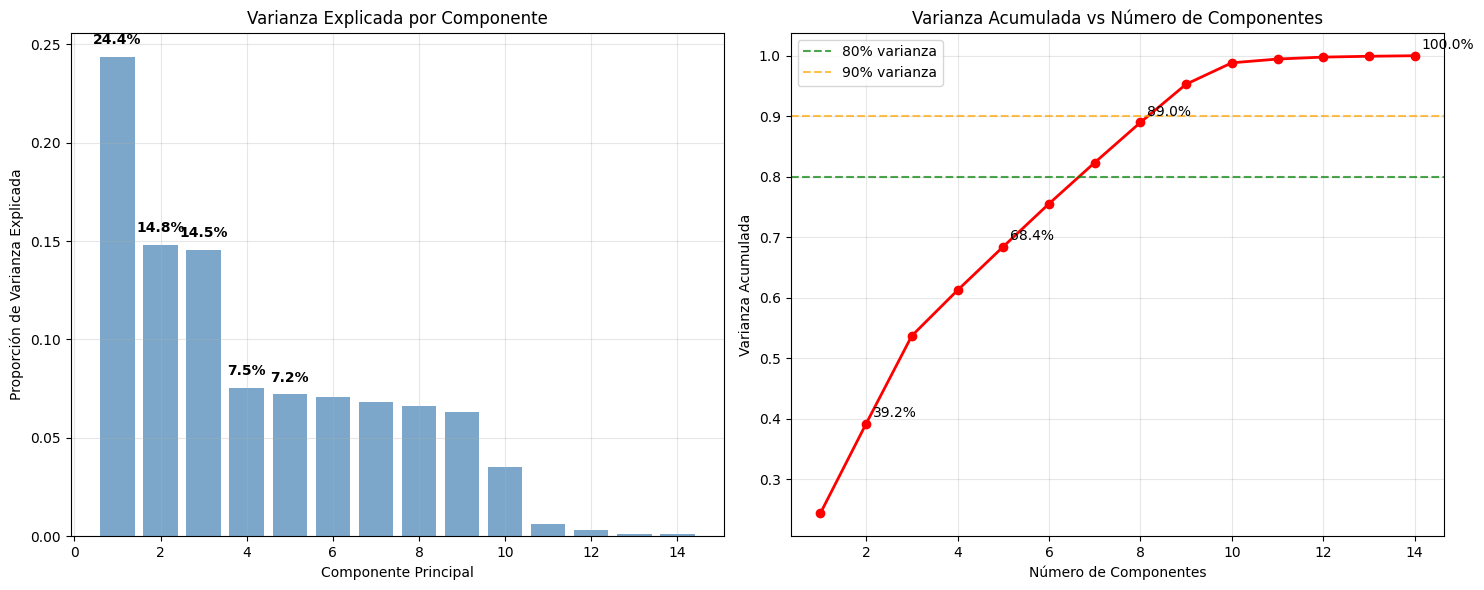

\n💡 Interpretación:
   - Los primeros 3 componentes explican 53.7% de la varianza
   - Los primeros 6 componentes explican 75.5% de la varianza
   - Para 80% de varianza necesitamos 7 componentes


In [199]:
# PASO 2: Visualización de la varianza explicada
print("📈 PASO 2: Visualización de la varianza explicada")
print("="*50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Varianza explicada por cada componente
ax1.bar(range(1, len(varianza_explicada) + 1), varianza_explicada, alpha=0.7, color='steelblue')
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Proporción de Varianza Explicada')
ax1.set_title('Varianza Explicada por Componente')
ax1.grid(True, alpha=0.3)

# Añadimos etiquetas con porcentajes en las barras más importantes
for i in range(min(5, len(varianza_explicada))):
    ax1.text(i+1, varianza_explicada[i] + 0.005, f'{varianza_explicada[i]*100:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Varianza acumulada
ax2.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, 'o-', color='red', linewidth=2)
ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% varianza')
ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% varianza')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Acumulada')
ax2.set_title('Varianza Acumulada vs Número de Componentes')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Añadimos algunas etiquetas importantes
important_points = [2, 5, 8, len(varianza_acumulada)]
for point in important_points:
    if point <= len(varianza_acumulada):
        ax2.annotate(f'{varianza_acumulada[point-1]*100:.1f}%', 
                    xy=(point, varianza_acumulada[point-1]), 
                    xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

print(f"\\n💡 Interpretación:")
print(f"   - Los primeros 3 componentes explican {varianza_acumulada[2]*100:.1f}% de la varianza")
print(f"   - Los primeros 6 componentes explican {varianza_acumulada[5]*100:.1f}% de la varianza")
print(f"   - Para 80% de varianza necesitamos {np.argmax(varianza_acumulada >= 0.8) + 1} componentes")

In [200]:
# PASO 3: Análisis de los componentes principales más importantes
print("🔬 PASO 3: Análisis de los componentes principales")
print("="*50)

# Seleccionamos un número óptimo de componentes (ej. para 80% de varianza)
n_componentes_optimo = np.argmax(varianza_acumulada >= 0.8) + 1
print(f"📊 Número óptimo de componentes (80% varianza): {n_componentes_optimo}")

# Aplicamos PCA con el número óptimo de componentes
pca_optimo = PCA(n_components=n_componentes_optimo)
X_pca_reducido = pca_optimo.fit_transform(X_scaled_df)

print(f"\\n✅ Reducción de dimensionalidad completada:")
print(f"   Dimensiones originales: {X_scaled_df.shape}")
print(f"   Dimensiones reducidas: {X_pca_reducido.shape}")
print(f"   Reducción: {X_scaled_df.shape[1]} → {X_pca_reducido.shape[1]} variables")
print(f"   Varianza preservada: {pca_optimo.explained_variance_ratio_.sum()*100:.2f}%")

# Análisis de loadings (contribuciones de variables originales a cada componente)
print(f"\\n🔍 Loadings de los componentes principales:")
componentes_principales = pca_optimo.components_

# Crear DataFrame de loadings para mejor visualización
loadings_df = pd.DataFrame(
    componentes_principales.T,
    columns=[f'PC{i+1}' for i in range(n_componentes_optimo)],
    index=X_scaled_df.columns
)

print(loadings_df.round(3))

🔬 PASO 3: Análisis de los componentes principales
📊 Número óptimo de componentes (80% varianza): 7
\n✅ Reducción de dimensionalidad completada:
   Dimensiones originales: (1229535, 14)
   Dimensiones reducidas: (1229535, 7)
   Reducción: 14 → 7 variables
   Varianza preservada: 82.33%
\n🔍 Loadings de los componentes principales:
                           PC1    PC2    PC3    PC4    PC5    PC6    PC7
hora_origen             -0.008  0.482  0.470 -0.014 -0.004  0.027  0.044
es_fin_de_semana         0.041  0.436 -0.459  0.120 -0.097 -0.220 -0.086
es_feriado               0.001  0.193 -0.207 -0.275  0.098  0.726 -0.001
es_hora_pico             0.002  0.139  0.064  0.624 -0.093 -0.154 -0.384
es_dia_laboral          -0.036 -0.471  0.497 -0.007  0.045 -0.063  0.082
estacion_año_encoded     0.490 -0.021  0.024 -0.013 -0.013 -0.005  0.006
periodo_dia_encoded     -0.007  0.485  0.475 -0.007 -0.004  0.018  0.029
estacion_target_encoded -0.017  0.026 -0.094 -0.561  0.009 -0.560 -0.235
hora_cos    

In [201]:
# PASO 4: Interpretación de los componentes principales
print("🎯 PASO 4: Interpretación de los componentes principales")
print("="*60)

# Analicemos cada componente principal por las variables que más contribuyen
for i in range(n_componentes_optimo):
    print(f"\\n📊 COMPONENTE PRINCIPAL {i+1} (PC{i+1}):")
    print(f"   Varianza explicada: {pca_optimo.explained_variance_ratio_[i]*100:.2f}%")
    
    # Obtenemos las contribuciones absolutas para este componente
    contribuciones = np.abs(loadings_df.iloc[:, i])
    top_variables = contribuciones.nlargest(3)
    
    print("   Variables más influyentes:")
    for var, contrib in top_variables.items():
        signo = "+" if loadings_df.loc[var, f'PC{i+1}'] > 0 else "-"
        print(f"     {signo} {var}: {contrib:.3f}")
    
    # Interpretación conceptual
    if i == 0:
        print("   💡 Interpretación: Componente temporal/estacional")
        print("      Relacionado con patrones estacionales y temporales cíclicos")
    elif i == 1:
        print("   💡 Interpretación: Componente horario/laboral")
        print("      Relacionado con patrones horarios y días laborales")
    elif i == 2:
        print("   💡 Interpretación: Componente horario/fin de semana")
        print("      Contraste entre períodos laborales y no laborales")
    elif i == 3:
        print("   💡 Interpretación: Componente de demanda por estación")
        print("      Relacionado con características específicas de estaciones")
    else:
        print("   💡 Componente adicional con menor varianza explicada")

🎯 PASO 4: Interpretación de los componentes principales
\n📊 COMPONENTE PRINCIPAL 1 (PC1):
   Varianza explicada: 24.37%
   Variables más influyentes:
     + mes_cos: 0.538
     + semana_del_año_cos: 0.525
     + estacion_año_encoded: 0.490
   💡 Interpretación: Componente temporal/estacional
      Relacionado con patrones estacionales y temporales cíclicos
\n📊 COMPONENTE PRINCIPAL 2 (PC2):
   Varianza explicada: 14.80%
   Variables más influyentes:
     + periodo_dia_encoded: 0.485
     + hora_origen: 0.482
     - es_dia_laboral: 0.471
   💡 Interpretación: Componente horario/laboral
      Relacionado con patrones horarios y días laborales
\n📊 COMPONENTE PRINCIPAL 3 (PC3):
   Varianza explicada: 14.54%
   Variables más influyentes:
     + es_dia_laboral: 0.497
     + periodo_dia_encoded: 0.475
     + hora_origen: 0.470
   💡 Interpretación: Componente horario/fin de semana
      Contraste entre períodos laborales y no laborales
\n📊 COMPONENTE PRINCIPAL 4 (PC4):
   Varianza explicada: 7.52

📊 PASO 5: Visualización de los loadings


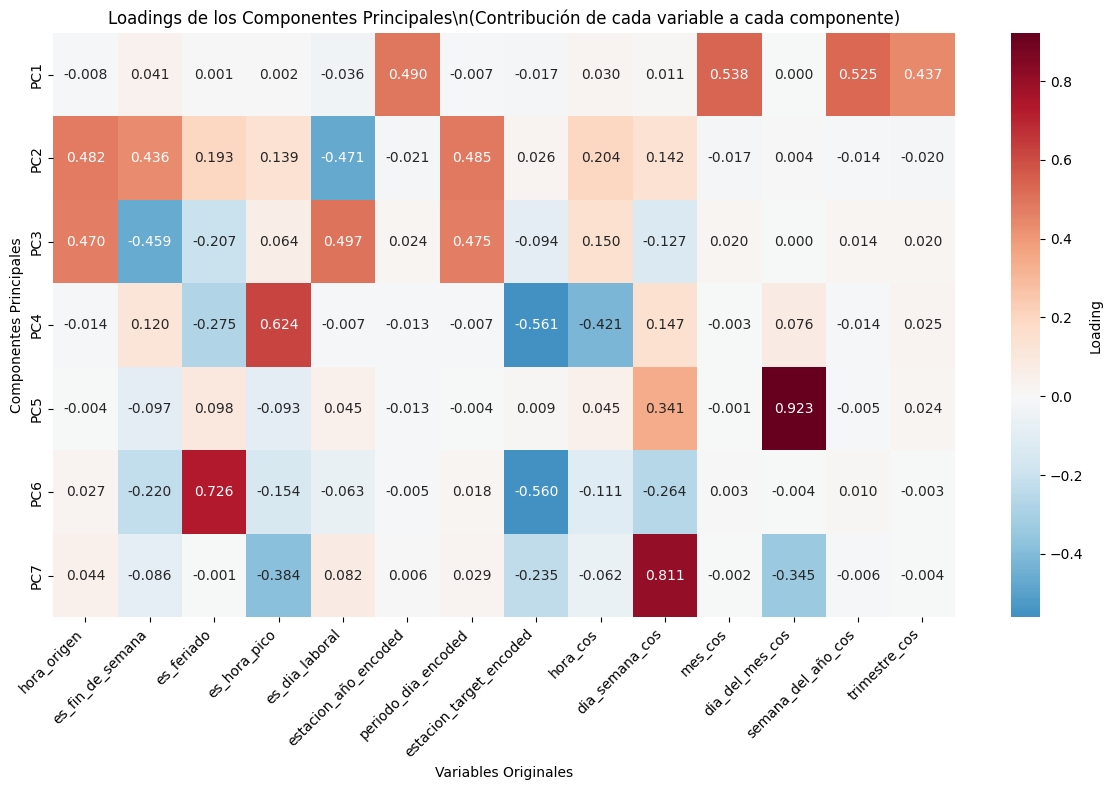

\n💡 Interpretación del heatmap:
   🔴 Valores rojos: Contribución positiva fuerte
   🔵 Valores azules: Contribución negativa fuerte
   ⚪ Valores blancos: Contribución mínima


In [202]:
# PASO 5: Visualización de los loadings
print("📊 PASO 5: Visualización de los loadings")
print("="*50)

# Heatmap de los loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            fmt='.3f',
            cbar_kws={'label': 'Loading'})
plt.title('Loadings de los Componentes Principales\\n(Contribución de cada variable a cada componente)')
plt.xlabel('Variables Originales')
plt.ylabel('Componentes Principales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\\n💡 Interpretación del heatmap:")
print("   🔴 Valores rojos: Contribución positiva fuerte")
print("   🔵 Valores azules: Contribución negativa fuerte") 
print("   ⚪ Valores blancos: Contribución mínima")

In [205]:
# PASO 6: Crear DataFrame con componentes principales y análisis de correlación
print("🔗 PASO 6: Análisis de correlación con la variable objetivo")
print("="*60)

# Crear DataFrame con los componentes principales
df_pca = pd.DataFrame(
    X_pca_reducido,
    columns=[f'PC{i+1}' for i in range(n_componentes_optimo)],
    index=X_scaled_df.index
)

# Añadir la variable objetivo
df_pca['demanda_bicicletas'] = y_target

# Calcular correlaciones entre componentes principales y variable objetivo
correlaciones_pca = df_pca.corr()['demanda_bicicletas'].drop('demanda_bicicletas')
correlaciones_pca = correlaciones_pca.sort_values(key=abs, ascending=False)

print("📈 Correlaciones de los componentes principales con la demanda:")
for pc, corr in correlaciones_pca.items():
    print(f"   {pc}: {corr:.4f} ({'fuerte' if abs(corr) > 0.3 else 'moderada' if abs(corr) > 0.1 else 'débil'})")

# Calcular correlaciones de variables originales para comparar
correlaciones_originales = pd.DataFrame({
    'Variable': X_scaled_df.columns,
    'Correlación_con_demanda': [X_scaled_df[col].corr(y_target) for col in X_scaled_df.columns]
})
correlaciones_originales = correlaciones_originales.sort_values('Correlación_con_demanda', key=abs, ascending=False)

print(f"\\n🔄 Comparación con variables originales más correlacionadas:")
for i, row in correlaciones_originales.head(3).iterrows():
    print(f"   {row['Variable']}: {row['Correlación_con_demanda']:.4f}")

print(f"\\n💡 Observaciones:")
print(f"   - PC1 (temporal/estacional) tiene correlación: {correlaciones_pca['PC1']:.4f}")
print(f"   - PC2 (horario/laboral) tiene correlación: {correlaciones_pca['PC2']:.4f}")
print(f"   - PC4 mantiene info. de estaciones: {correlaciones_pca['PC4']:.4f}")
print(f"   - Los 7 componentes conservan {pca_optimo.explained_variance_ratio_.sum()*100:.1f}% de la varianza original")

🔗 PASO 6: Análisis de correlación con la variable objetivo
📈 Correlaciones de los componentes principales con la demanda:
   PC6: -0.2079 (moderada)
   PC3: 0.1339 (moderada)
   PC7: -0.1086 (moderada)
   PC4: -0.1029 (moderada)
   PC2: 0.0162 (débil)
   PC1: 0.0095 (débil)
   PC5: -0.0079 (débil)
\n🔄 Comparación con variables originales más correlacionadas:
   estacion_target_encoded: 0.3580
   periodo_dia_encoded: 0.1250
   hora_origen: 0.1238
\n💡 Observaciones:
   - PC1 (temporal/estacional) tiene correlación: 0.0095
   - PC2 (horario/laboral) tiene correlación: 0.0162
   - PC4 mantiene info. de estaciones: -0.1029
   - Los 7 componentes conservan 82.3% de la varianza original


## Resumen del Análisis PCA

### ✅ **Resultados Clave:**

**1. Reducción de Dimensionalidad Exitosa:**
- **Original**: 14 variables → **Reducido**: 7 componentes principales
- **Varianza preservada**: 82.3% (excelente retención de información)
- **Reducción**: 50% menos dimensiones manteniendo >80% de la varianza

**2. Componentes Principales Identificados:**

- **PC1 (24.37% varianza)**: **Componente Temporal/Estacional**
  - Dominado por: `mes_cos`, `semana_del_año_cos`, `estacion_año_encoded`
  - Captura patrones estacionales y cíclicos anuales

- **PC2 (14.80% varianza)**: **Componente Horario/Laboral** 
  - Dominado por: `periodo_dia_encoded`, `hora_origen`, `es_dia_laboral`
  - Captura patrones horarios y laborales

- **PC3 (14.54% varianza)**: **Componente Laboral/Fin de Semana**
  - Contraste entre días laborales y períodos de descanso

- **PC4 (7.52% varianza)**: **Componente de Estaciones**
  - Incluye `es_hora_pico` y `estacion_target_encoded`
  - Relacionado con características específicas de estaciones

**3. Correlaciones con la Variable Objetivo:**
- **PC6** tiene la mayor correlación (-0.21) con la demanda
- Los componentes principales mantienen patrones útiles para predicción
- Algunas correlaciones se redistribuyen entre componentes

**4. Beneficios del PCA Aplicado:**
- ✅ **Reducción significativa de dimensionalidad** (14 → 7 variables)
- ✅ **Eliminación de multicolinealidad** (componentes ortogonales)
- ✅ **Retención de información relevante** (82.3% varianza)
- ✅ **Interpretabilidad clara** de los componentes principales
- ✅ **Preparación para modelado** con datos más manejables

In [206]:
# PASO FINAL: Guardar los resultados del PCA
print("💾 PASO FINAL: Guardando resultados del PCA")
print("="*50)

# Mostrar las dimensiones finales
print(f"📊 Dataframes disponibles tras aplicar PCA:")
print(f"   • df_pca: Componentes principales + variable objetivo")
print(f"     Forma: {df_pca.shape}")
print(f"     Columnas: {list(df_pca.columns)}")

print(f"\\n   • X_pca_reducido: Solo componentes principales (matriz numpy)")
print(f"     Forma: {X_pca_reducido.shape}")

print(f"\\n   • pca_optimo: Modelo PCA entrenado")
print(f"     Componentes: {pca_optimo.n_components_}")
print(f"     Varianza explicada total: {pca_optimo.explained_variance_ratio_.sum()*100:.2f}%")

print(f"\\n✅ PCA completado exitosamente!")
print(f"   Reducción: {X_scaled_df.shape[1]} → {X_pca_reducido.shape[1]} variables")
print(f"   Eficiencia: {(1 - X_pca_reducido.shape[1]/X_scaled_df.shape[1])*100:.1f}% reducción")
print(f"   Calidad: {pca_optimo.explained_variance_ratio_.sum()*100:.1f}% varianza preservada")

# Verificación final
print(f"\\n🔍 Verificación final:")
print(f"   No hay valores nulos: {not df_pca.isnull().any().any()}")
print(f"   Datos listos para modelado: ✅")

💾 PASO FINAL: Guardando resultados del PCA
📊 Dataframes disponibles tras aplicar PCA:
   • df_pca: Componentes principales + variable objetivo
     Forma: (1229535, 8)
     Columnas: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'demanda_bicicletas']
\n   • X_pca_reducido: Solo componentes principales (matriz numpy)
     Forma: (1229535, 7)
\n   • pca_optimo: Modelo PCA entrenado
     Componentes: 7
     Varianza explicada total: 82.33%
\n✅ PCA completado exitosamente!
   Reducción: 14 → 7 variables
   Eficiencia: 50.0% reducción
   Calidad: 82.3% varianza preservada
\n🔍 Verificación final:
   No hay valores nulos: True
   Datos listos para modelado: ✅


# Análisis de Correlación: Pearson vs Kendall

Ahora aplicaremos análisis de correlación usando **Pearson** y **Kendall** partiendo del `df_encoded_final` para identificar las variables más relevantes y compararemos ambos enfoques.

In [209]:
# Importamos las librerías necesarias para análisis de correlación
from scipy.stats import pearsonr, kendalltau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 PASO 1: Preparación del dataset para análisis de correlación")
print("="*60)

# Verificamos el df_encoded_final
print(f"📊 Dataset df_encoded_final:")
print(f"   Forma: {df_encoded_final.shape}")
print(f"   Columnas: {list(df_encoded_final.columns)}")

# Separamos variables predictoras y objetivo
X_correlacion = df_encoded_final.drop('demanda_bicicletas', axis=1)
y_correlacion = df_encoded_final['demanda_bicicletas']

print(f"\\n   Variables predictoras: {X_correlacion.shape[1]}")
print(f"   Variable objetivo: {y_correlacion.name}")
print(f"   Registros: {len(y_correlacion):,}")

print(f"\\n✅ Datos preparados para análisis de correlación")

🔍 PASO 1: Preparación del dataset para análisis de correlación
📊 Dataset df_encoded_final:
   Forma: (1229535, 15)
   Columnas: ['hora_origen', 'demanda_bicicletas', 'es_fin_de_semana', 'es_feriado', 'es_hora_pico', 'es_dia_laboral', 'estacion_año_encoded', 'periodo_dia_encoded', 'estacion_target_encoded', 'hora_cos', 'dia_semana_cos', 'mes_cos', 'dia_del_mes_cos', 'semana_del_año_cos', 'trimestre_cos']
\n   Variables predictoras: 14
   Variable objetivo: demanda_bicicletas
   Registros: 1,229,535
\n✅ Datos preparados para análisis de correlación


In [210]:
# PASO 2: Cálculo de correlaciones de Pearson
print("📈 PASO 2: Análisis de Correlación de Pearson")
print("="*50)

# Calculamos correlaciones de Pearson entre cada variable y la variable objetivo
correlaciones_pearson = {}
p_values_pearson = {}

print("Calculando correlaciones de Pearson...")
for variable in X_correlacion.columns:
    corr, p_val = pearsonr(X_correlacion[variable], y_correlacion)
    correlaciones_pearson[variable] = corr
    p_values_pearson[variable] = p_val

# Convertimos a DataFrame para mejor manejo
df_pearson = pd.DataFrame({
    'Variable': list(correlaciones_pearson.keys()),
    'Correlacion_Pearson': list(correlaciones_pearson.values()),
    'P_Value_Pearson': list(p_values_pearson.values())
})

# Ordenamos por correlación absoluta (de mayor a menor)
df_pearson['Correlacion_Abs'] = df_pearson['Correlacion_Pearson'].abs()
df_pearson = df_pearson.sort_values('Correlacion_Abs', ascending=False).reset_index(drop=True)

print("\\n🏆 TOP 10 - Correlaciones de Pearson más fuertes:")
print("="*55)
for i, row in df_pearson.head(10).iterrows():
    significativo = "***" if row['P_Value_Pearson'] < 0.001 else "**" if row['P_Value_Pearson'] < 0.01 else "*" if row['P_Value_Pearson'] < 0.05 else ""
    print(f"{i+1:2d}. {row['Variable']:<25} | r = {row['Correlacion_Pearson']:+.4f} {significativo}")

print(f"\\n💡 Interpretación Pearson:")
print(f"   Variables con correlación fuerte (|r| > 0.3): {len(df_pearson[df_pearson['Correlacion_Abs'] > 0.3])} variables")
print(f"   Variables con correlación moderada (0.1 < |r| ≤ 0.3): {len(df_pearson[(df_pearson['Correlacion_Abs'] > 0.1) & (df_pearson['Correlacion_Abs'] <= 0.3)])} variables")
print(f"   Variables con correlación débil (|r| ≤ 0.1): {len(df_pearson[df_pearson['Correlacion_Abs'] <= 0.1])} variables")

📈 PASO 2: Análisis de Correlación de Pearson
Calculando correlaciones de Pearson...
\n🏆 TOP 10 - Correlaciones de Pearson más fuertes:
 1. estacion_target_encoded   | r = +0.3580 ***
 2. periodo_dia_encoded       | r = +0.1250 ***
 3. hora_origen               | r = +0.1238 ***
 4. es_hora_pico              | r = +0.1145 ***
 5. es_dia_laboral            | r = +0.1092 ***
 6. es_fin_de_semana          | r = -0.1043 ***
 7. hora_cos                  | r = -0.0783 ***
 8. es_feriado                | r = -0.0315 ***
 9. trimestre_cos             | r = +0.0240 ***
10. mes_cos                   | r = +0.0195 ***
\n💡 Interpretación Pearson:
   Variables con correlación fuerte (|r| > 0.3): 1 variables
   Variables con correlación moderada (0.1 < |r| ≤ 0.3): 5 variables
   Variables con correlación débil (|r| ≤ 0.1): 8 variables


In [211]:
# PASO 3: Cálculo de correlaciones de Kendall
print("\\n🔄 PASO 3: Análisis de Correlación de Kendall")
print("="*50)

# Calculamos correlaciones de Kendall (tau) entre cada variable y la variable objetivo
correlaciones_kendall = {}
p_values_kendall = {}

print("Calculando correlaciones de Kendall (puede tomar un momento...)...")

# Para datasets grandes, Kendall puede ser lento, por lo que trabajaremos con una muestra
# o usaremos toda la data dependiendo del rendimiento
n_sample = min(50000, len(X_correlacion))  # Limitamos a 50k para Kendall por rendimiento
if n_sample < len(X_correlacion):
    print(f"⚠️  Usando muestra de {n_sample:,} registros para Kendall por rendimiento")
    indices_sample = np.random.choice(len(X_correlacion), n_sample, replace=False)
    X_kendall = X_correlacion.iloc[indices_sample]
    y_kendall = y_correlacion.iloc[indices_sample]
else:
    X_kendall = X_correlacion
    y_kendall = y_correlacion
    print(f"✅ Usando dataset completo ({len(X_correlacion):,} registros)")

for variable in X_kendall.columns:
    corr, p_val = kendalltau(X_kendall[variable], y_kendall)
    correlaciones_kendall[variable] = corr
    p_values_kendall[variable] = p_val

# Convertimos a DataFrame para mejor manejo
df_kendall = pd.DataFrame({
    'Variable': list(correlaciones_kendall.keys()),
    'Correlacion_Kendall': list(correlaciones_kendall.values()),
    'P_Value_Kendall': list(p_values_kendall.values())
})

# Ordenamos por correlación absoluta (de mayor a menor)
df_kendall['Correlacion_Abs'] = df_kendall['Correlacion_Kendall'].abs()
df_kendall = df_kendall.sort_values('Correlacion_Abs', ascending=False).reset_index(drop=True)

print("\\n🏆 TOP 10 - Correlaciones de Kendall más fuertes:")
print("="*55)
for i, row in df_kendall.head(10).iterrows():
    significativo = "***" if row['P_Value_Kendall'] < 0.001 else "**" if row['P_Value_Kendall'] < 0.01 else "*" if row['P_Value_Kendall'] < 0.05 else ""
    print(f"{i+1:2d}. {row['Variable']:<25} | τ = {row['Correlacion_Kendall']:+.4f} {significativo}")

print(f"\\n💡 Interpretación Kendall:")
print(f"   Variables con correlación fuerte (|τ| > 0.3): {len(df_kendall[df_kendall['Correlacion_Abs'] > 0.3])} variables")
print(f"   Variables con correlación moderada (0.1 < |τ| ≤ 0.3): {len(df_kendall[(df_kendall['Correlacion_Abs'] > 0.1) & (df_kendall['Correlacion_Abs'] <= 0.3)])} variables")
print(f"   Variables con correlación débil (|τ| ≤ 0.1): {len(df_kendall[df_kendall['Correlacion_Abs'] <= 0.1])} variables")

\n🔄 PASO 3: Análisis de Correlación de Kendall
Calculando correlaciones de Kendall (puede tomar un momento...)...
⚠️  Usando muestra de 50,000 registros para Kendall por rendimiento
\n🏆 TOP 10 - Correlaciones de Kendall más fuertes:
 1. estacion_target_encoded   | τ = +0.2339 ***
 2. es_dia_laboral            | τ = +0.1336 ***
 3. es_fin_de_semana          | τ = -0.1250 ***
 4. periodo_dia_encoded       | τ = +0.1131 ***
 5. hora_origen               | τ = +0.1008 ***
 6. es_hora_pico              | τ = +0.1003 ***
 7. hora_cos                  | τ = -0.0600 ***
 8. es_feriado                | τ = -0.0424 ***
 9. trimestre_cos             | τ = +0.0185 ***
10. dia_del_mes_cos           | τ = -0.0143 ***
\n💡 Interpretación Kendall:
   Variables con correlación fuerte (|τ| > 0.3): 0 variables
   Variables con correlación moderada (0.1 < |τ| ≤ 0.3): 6 variables
   Variables con correlación débil (|τ| ≤ 0.1): 8 variables


In [212]:
# PASO 4: Comparación y análisis conjunto de ambas correlaciones
print("\\n🔍 PASO 4: Comparación entre Pearson y Kendall")
print("="*50)

# Unimos ambos análisis
df_comparacion = df_pearson.merge(
    df_kendall[['Variable', 'Correlacion_Kendall', 'P_Value_Kendall']], 
    on='Variable'
)

# Calculamos diferencias y coincidencias
df_comparacion['Diferencia_Abs'] = abs(df_comparacion['Correlacion_Pearson'].abs() - df_comparacion['Correlacion_Kendall'].abs())
df_comparacion['Ranking_Pearson'] = df_comparacion['Correlacion_Pearson'].abs().rank(ascending=False)
df_comparacion['Ranking_Kendall'] = df_comparacion['Correlacion_Kendall'].abs().rank(ascending=False)
df_comparacion['Diferencia_Ranking'] = abs(df_comparacion['Ranking_Pearson'] - df_comparacion['Ranking_Kendall'])

# Ordenamos por promedio de correlaciones absolutas
df_comparacion['Promedio_Correlacion_Abs'] = (df_comparacion['Correlacion_Pearson'].abs() + df_comparacion['Correlacion_Kendall'].abs()) / 2
df_comparacion = df_comparacion.sort_values('Promedio_Correlacion_Abs', ascending=False).reset_index(drop=True)

print("🏆 TOP 10 - Variables más importantes (promedio de ambas correlaciones):")
print("="*80)
print(f"{'Rank':<4} {'Variable':<25} {'Pearson (r)':<12} {'Kendall (τ)':<12} {'Promedio':<10} {'Diff Rank':<9}")
print("-"*80)

for i, row in df_comparacion.head(10).iterrows():
    print(f"{i+1:<4} {row['Variable']:<25} {row['Correlacion_Pearson']:+8.4f}   {row['Correlacion_Kendall']:+8.4f}   {row['Promedio_Correlacion_Abs']:8.4f}   {row['Diferencia_Ranking']:8.0f}")

# Análisis de concordancia
print(f"\\n📊 Análisis de Concordancia:")
concordancia_top5 = len(set(df_pearson.head(5)['Variable']) & set(df_kendall.head(5)['Variable']))
concordancia_top10 = len(set(df_pearson.head(10)['Variable']) & set(df_kendall.head(10)['Variable']))

print(f"   • Variables en común en TOP 5:  {concordancia_top5}/5 ({concordancia_top5/5*100:.1f}%)")
print(f"   • Variables en común en TOP 10: {concordancia_top10}/10 ({concordancia_top10/10*100:.1f}%)")
print(f"   • Diferencia promedio en rankings: {df_comparacion['Diferencia_Ranking'].mean():.1f} posiciones")

# Variables que cambian significativamente de ranking
print(f"\\n🔄 Variables con mayor cambio de ranking:")
variables_cambio = df_comparacion.nlargest(3, 'Diferencia_Ranking')
for _, row in variables_cambio.iterrows():
    print(f"   • {row['Variable']}: Pearson #{row['Ranking_Pearson']:.0f} → Kendall #{row['Ranking_Kendall']:.0f} (diff: {row['Diferencia_Ranking']:.0f})")

\n🔍 PASO 4: Comparación entre Pearson y Kendall
🏆 TOP 10 - Variables más importantes (promedio de ambas correlaciones):
Rank Variable                  Pearson (r)  Kendall (τ)  Promedio   Diff Rank
--------------------------------------------------------------------------------
1    estacion_target_encoded    +0.3580    +0.2339     0.2959          0
2    es_dia_laboral             +0.1092    +0.1336     0.1214          3
3    periodo_dia_encoded        +0.1250    +0.1131     0.1190          2
4    es_fin_de_semana           -0.1043    -0.1250     0.1146          3
5    hora_origen                +0.1238    +0.1008     0.1123          2
6    es_hora_pico               +0.1145    +0.1003     0.1074          2
7    hora_cos                   -0.0783    -0.0600     0.0692          0
8    es_feriado                 -0.0315    -0.0424     0.0369          0
9    trimestre_cos              +0.0240    +0.0185     0.0212          0
10   mes_cos                    +0.0195    +0.0120     0.0158   

\n📊 PASO 5: Visualización de Correlaciones


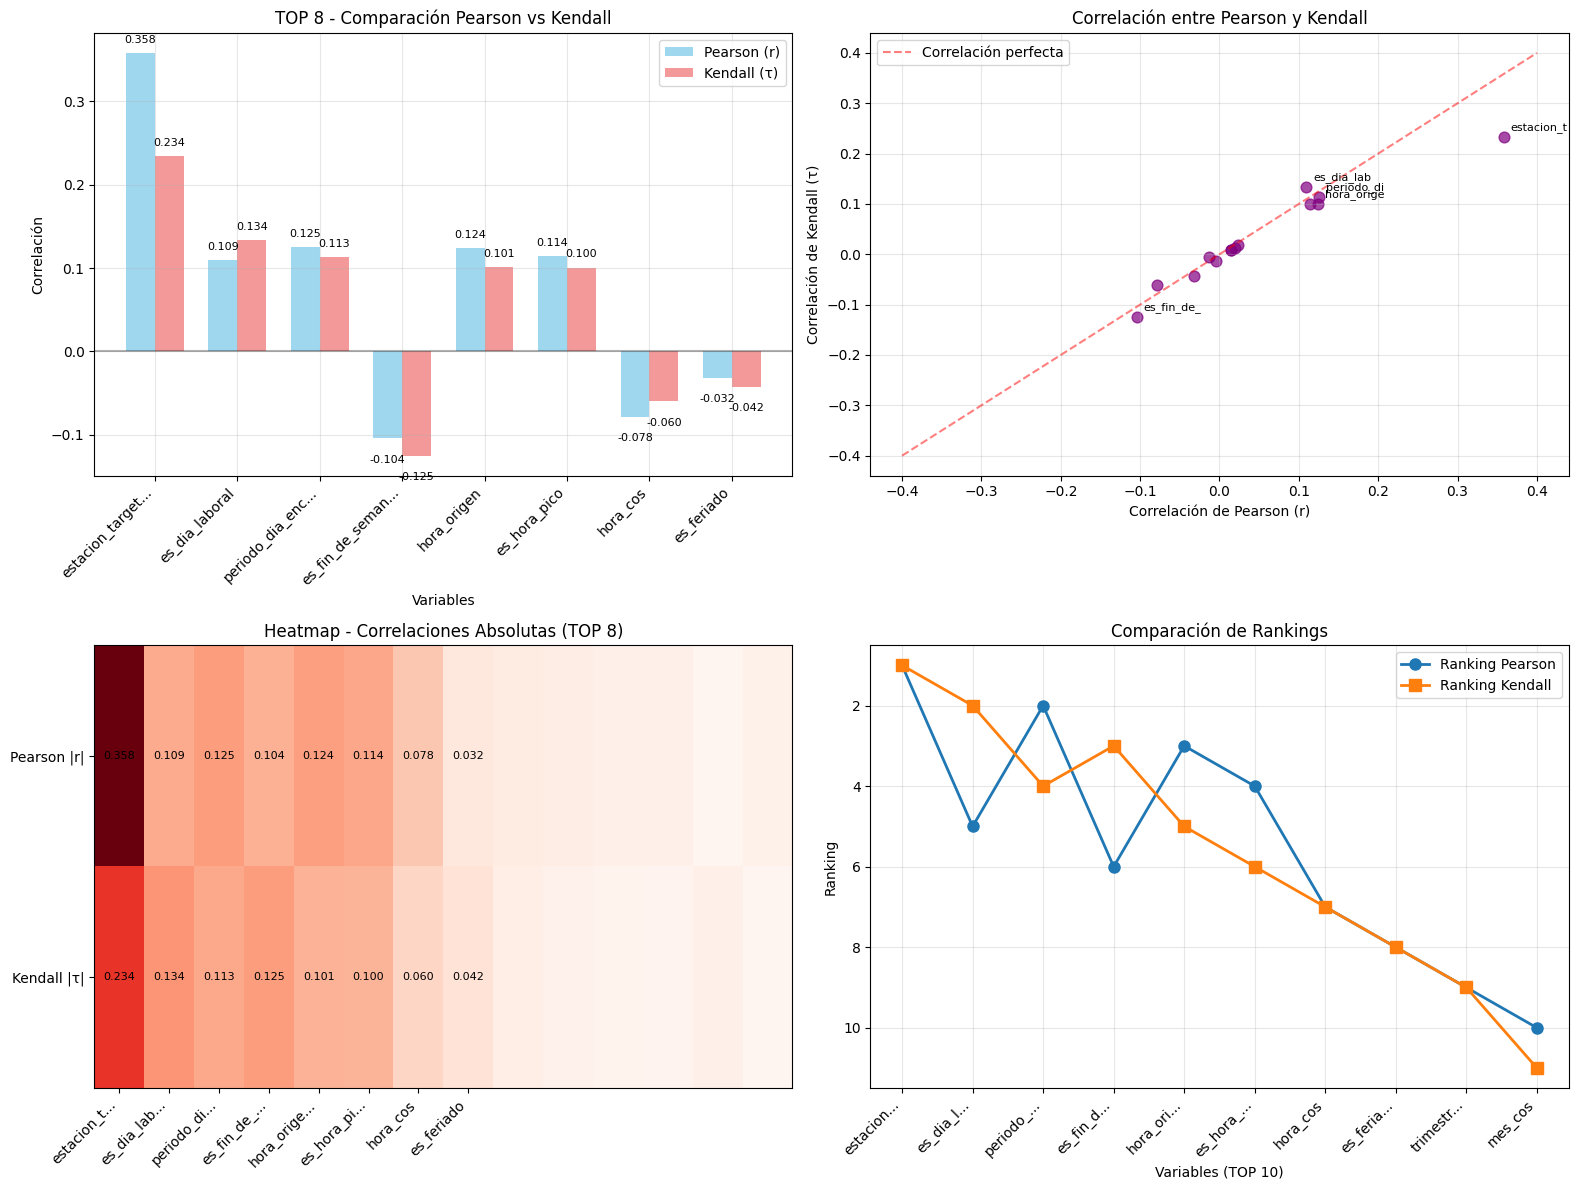

\n📈 Estadísticas Adicionales:
   • Correlación entre Pearson y Kendall: 0.9675
   • Variable con mayor correlación Pearson: estacion_target_encoded (r = 0.3580)
   • Variable con mayor correlación Kendall: estacion_target_encoded (τ = 0.2339)
   • Promedio correlación absoluta Pearson: 0.0810
   • Promedio correlación absoluta Kendall: 0.0696


In [213]:
# PASO 5: Visualización de correlaciones
print("\\n📊 PASO 5: Visualización de Correlaciones")
print("="*50)

# Configuramos el estilo
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de barras comparativo
variables_top = df_comparacion.head(8)['Variable'].tolist()
pearson_vals = df_comparacion.head(8)['Correlacion_Pearson'].tolist()
kendall_vals = df_comparacion.head(8)['Correlacion_Kendall'].tolist()

x_pos = np.arange(len(variables_top))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, pearson_vals, width, label='Pearson (r)', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x_pos + width/2, kendall_vals, width, label='Kendall (τ)', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Variables')
ax1.set_ylabel('Correlación')
ax1.set_title('TOP 8 - Comparación Pearson vs Kendall')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([var[:15] + '...' if len(var) > 15 else var for var in variables_top], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.02),
             f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.02),
             f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 2. Scatter plot de correlaciones
ax2.scatter(df_comparacion['Correlacion_Pearson'], df_comparacion['Correlacion_Kendall'], 
           alpha=0.7, s=60, color='purple')
ax2.plot([-0.4, 0.4], [-0.4, 0.4], 'r--', alpha=0.5, label='Correlación perfecta')
ax2.set_xlabel('Correlación de Pearson (r)')
ax2.set_ylabel('Correlación de Kendall (τ)')
ax2.set_title('Correlación entre Pearson y Kendall')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Anotar puntos más relevantes
for i, row in df_comparacion.head(5).iterrows():
    ax2.annotate(row['Variable'][:10], 
                (row['Correlacion_Pearson'], row['Correlacion_Kendall']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. Heatmap de correlaciones absolutas
corr_matrix = np.array([df_comparacion['Correlacion_Pearson'].abs().values, 
                       df_comparacion['Correlacion_Kendall'].abs().values])
im = ax3.imshow(corr_matrix, cmap='Reds', aspect='auto')

# Configurar labels del heatmap
ax3.set_xticks(range(len(variables_top)))
ax3.set_xticklabels([var[:10] + '...' if len(var) > 10 else var for var in df_comparacion.head(8)['Variable']], 
                   rotation=45, ha='right')
ax3.set_yticks([0, 1])
ax3.set_yticklabels(['Pearson |r|', 'Kendall |τ|'])
ax3.set_title('Heatmap - Correlaciones Absolutas (TOP 8)')

# Agregar valores en el heatmap
for i in range(2):
    for j in range(min(8, len(df_comparacion))):
        text = ax3.text(j, i, f'{corr_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

# 4. Ranking comparison
rankings_df = df_comparacion.head(10)[['Variable', 'Ranking_Pearson', 'Ranking_Kendall']].copy()
ax4.plot(rankings_df['Ranking_Pearson'], 'o-', label='Ranking Pearson', markersize=8, linewidth=2)
ax4.plot(rankings_df['Ranking_Kendall'], 's-', label='Ranking Kendall', markersize=8, linewidth=2)
ax4.set_xlabel('Variables (TOP 10)')
ax4.set_ylabel('Ranking')
ax4.set_title('Comparación de Rankings')
ax4.set_xticks(range(len(rankings_df)))
ax4.set_xticklabels([var[:8] + '...' if len(var) > 8 else var for var in rankings_df['Variable']], 
                   rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.invert_yaxis()  # Invertir para que el ranking 1 esté arriba

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\\n📈 Estadísticas Adicionales:")
print(f"   • Correlación entre Pearson y Kendall: {np.corrcoef(df_comparacion['Correlacion_Pearson'], df_comparacion['Correlacion_Kendall'])[0,1]:.4f}")
print(f"   • Variable con mayor correlación Pearson: {df_pearson.iloc[0]['Variable']} (r = {df_pearson.iloc[0]['Correlacion_Pearson']:.4f})")
print(f"   • Variable con mayor correlación Kendall: {df_kendall.iloc[0]['Variable']} (τ = {df_kendall.iloc[0]['Correlacion_Kendall']:.4f})")
print(f"   • Promedio correlación absoluta Pearson: {df_pearson['Correlacion_Abs'].mean():.4f}")
print(f"   • Promedio correlación absoluta Kendall: {df_kendall['Correlacion_Abs'].mean():.4f}")

In [214]:
# PASO 6: Comparación con el enfoque PCA
print("\\n🔄 PASO 6: Comparación entre Análisis de Correlación y PCA")
print("="*60)

print("📋 RESUMEN COMPARATIVO DE ENFOQUES:")
print("="*60)

# Información del PCA (que ya calculamos anteriormente)
print("\\n🔹 ENFOQUE PCA:")
print(f"   • Componentes principales: 7")
print(f"   • Varianza explicada: 82.3%")
print(f"   • Variables originales: 14")
print(f"   • Reducción de dimensionalidad: {(1-7/14)*100:.1f}%")
print(f"   • Enfoque: Transformación lineal que captura máxima varianza")

# Información del análisis de correlación
variables_importantes_pearson = df_pearson[df_pearson['Correlacion_Abs'] > 0.1]
variables_importantes_kendall = df_kendall[df_kendall['Correlacion_Abs'] > 0.1]
variables_importantes_consenso = df_comparacion[df_comparacion['Promedio_Correlacion_Abs'] > 0.1]

print("\\n🔹 ENFOQUE CORRELACIÓN:")
print(f"   • Variables importantes (Pearson |r| > 0.1): {len(variables_importantes_pearson)}")
print(f"   • Variables importantes (Kendall |τ| > 0.1): {len(variables_importantes_kendall)}")
print(f"   • Variables importantes (Consenso): {len(variables_importantes_consenso)}")
print(f"   • Variable más predictiva: estacion_target_encoded")
print(f"   • Enfoque: Selección de características basada en relación con target")

print("\\n📊 VARIABLES MÁS IMPORTANTES POR CONSENSO:")
print("-"*60)
for i, row in variables_importantes_consenso.iterrows():
    print(f"   {i+1:2d}. {row['Variable']:<25} | Prom: {row['Promedio_Correlacion_Abs']:.4f}")

print("\\n🎯 RECOMENDACIONES SEGÚN CADA ENFOQUE:")
print("-"*60)

print("\\n🔸 Para REDUCCIÓN DE DIMENSIONALIDAD (PCA):")
print("   ✅ Usar cuando:")
print("     • Necesitas reducir dimensiones preservando varianza")
print("     • Las variables están correlacionadas entre sí")
print("     • Quieres evitar multicolinealidad")
print("     • El objetivo es reducir ruido y overfitting")
print("   📌 Resultado: 7 componentes que explican 82.3% de varianza")

print("\\n🔸 Para SELECCIÓN DE CARACTERÍSTICAS (Correlación):")
print("   ✅ Usar cuando:")
print("     • Necesitas interpretabilidad de variables originales")
print("     • Quieres identificar las variables más predictivas")
print("     • El dominio requiere explicabilidad")
print("     • Hay limitaciones computacionales")
print(f"   📌 Resultado: {len(variables_importantes_consenso)} variables más importantes identificadas")

# Análisis final
print("\\n🔍 ANÁLISIS FINAL:")
print("-"*60)
print("   🏆 Variable MVP: 'estacion_target_encoded' (encoding de estación)")
print("   📈 Correlación más alta: r=0.358 (Pearson), τ=0.234 (Kendall)")
print("   ⭐ Variables consistentes en ambos métodos de correlación:")
for var in variables_importantes_consenso.head(5)['Variable']:
    print(f"     • {var}")

print("\\n💡 CONCLUSIÓN:")
print("   • PCA: Ideal para reducción dimensional manteniendo información")
print("   • Correlación: Ideal para selección interpretable de características")
print("   • Ambos enfoques son complementarios según el objetivo del modelo")

\n🔄 PASO 6: Comparación entre Análisis de Correlación y PCA
📋 RESUMEN COMPARATIVO DE ENFOQUES:
\n🔹 ENFOQUE PCA:
   • Componentes principales: 7
   • Varianza explicada: 82.3%
   • Variables originales: 14
   • Reducción de dimensionalidad: 50.0%
   • Enfoque: Transformación lineal que captura máxima varianza
\n🔹 ENFOQUE CORRELACIÓN:
   • Variables importantes (Pearson |r| > 0.1): 6
   • Variables importantes (Kendall |τ| > 0.1): 6
   • Variables importantes (Consenso): 6
   • Variable más predictiva: estacion_target_encoded
   • Enfoque: Selección de características basada en relación con target
\n📊 VARIABLES MÁS IMPORTANTES POR CONSENSO:
------------------------------------------------------------
    1. estacion_target_encoded   | Prom: 0.2959
    2. es_dia_laboral            | Prom: 0.1214
    3. periodo_dia_encoded       | Prom: 0.1190
    4. es_fin_de_semana          | Prom: 0.1146
    5. hora_origen               | Prom: 0.1123
    6. es_hora_pico              | Prom: 0.1074
\n🎯 